This notebook provides an example downstream analysis of a trained MOFA+ model in Python. 

[PBMC10K](https://support.10xgenomics.com/single-cell-gene-expression/datasets) dataset is used as an example, which might be familiar to some of the users of Seurat or scanpy. It is a 3' single-cell RNA sequencing data so only one layer of information (view) is available, that is gene expression.

For this tutorial, only a trained PBMC10k model is needed, and it can be downloaded [here](https://github.com/gtca/mpp/tree/master/data/models/pbmc10k.hdf5).

In [1]:
# Set root folder as a working directory
import os
os.chdir("../")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from matplotlib import rcParams
rcParams['figure.dpi'] = 200

# Connect to the model

In [4]:
! mkdir -p data/models
! wget https://github.com/gtca/mpp/tree/master/data/models/pbmc10k.hdf5

--2020-03-09 21:14:40--  https://github.com/gtca/mpp/tree/master/data/models/pbmc10k.hdf5
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/gtca/mofax/tree/master/data/models/pbmc10k.hdf5 [following]
--2020-03-09 21:14:41--  https://github.com/gtca/mofax/tree/master/data/models/pbmc10k.hdf5
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/gtca/mofax/blob/master/data/models/pbmc10k.hdf5 [following]
--2020-03-09 21:14:41--  https://github.com/gtca/mofax/blob/master/data/models/pbmc10k.hdf5
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: 'pbmc10k.hdf5.2'

pbmc10k.hdf5.2          [ <=>                ]  62.03K  --.-KB/s    in 0.03s   

2020-03-09 21:14:41 (

In [5]:
import mofax as mfx
m = mfx.mofa_model("data/models/pbmc10k.hdf5")

This creates a connection to an HDF5 file. According to best practices, it should be closed when the access is not needed anymore by calling `m.close()`.

## Basic model features

We can quickly check the overall dimensions of the model:

In [6]:
print(f"""\
Cells: {m.shape[0]}
Features: {m.shape[1]}
Groups of cells: {', '.join(m.groups)}
Views: {', '.join(m.views)}
""")

Cells: 10575
Features: 2071
Groups of cells: group1
Views: rna



The core part of the trained model are 2 matrices: Z (factors) and W (weights, or loadings) matrices. The expectations for Z or W are easily accessible in different formats:

In [7]:
# HDF5 group
print("HDF5 group:\n", m.weights)

# np.ndarray
print("\nnp.ndarray:\n", m.get_weights()[:3,:5])

# pd.DataFrame
print("\npd.DataFrame:\n", m.get_weights(df=True).iloc[:3,:5])

HDF5 group:
 <HDF5 group "/expectations/W" (1 members)>

np.ndarray:
 [[ 3.97031541e-04 -2.14016519e-04 -9.70952784e-03  1.42689823e-04
   2.17236696e-04]
 [ 2.27657894e-01 -1.17120174e-04 -8.19302633e-02  2.52041376e-05
   1.39462012e-05]
 [-5.08148227e-02 -7.67944288e-04 -1.57304689e-01  4.31494817e-02
  -8.83336484e-04]]

pd.DataFrame:
          Factor1   Factor2   Factor3   Factor4   Factor5
KLHL17  0.000397 -0.000214 -0.009710  0.000143  0.000217
HES4    0.227658 -0.000117 -0.081930  0.000025  0.000014
ISG15  -0.050815 -0.000768 -0.157305  0.043149 -0.000883


Same works for factors: try executing `m.factors`, `m.get_factors()`, and `m.get_factors(df=True)`.

The content below is devoted to demonstation of different plotting functions available and is divided into three parts:

1. exploring weights (loadings) of factors,
2. exploring factor values,
3. exploring variance explained by different factors in different groups of cells.

# Plotting weights

Loadings of a factor define a set of features that are important for this factor. In `mpp`, multiple ways to visualise factor loadings are implemented with `matplotlib` and `seaborn` libraries.

Currently the following functions are provided for plottings weights:
- `plot_weights`
- `plot_weights_dotplot`
- `plot_weights_heatmap`
- `plot_weights_scaled`
- `plot_weights_scatter`

## Weights ranked

A visualization of factor weights familiar to MOFA and MOFA+ users is implemented with some modifications in `plot_weights`.

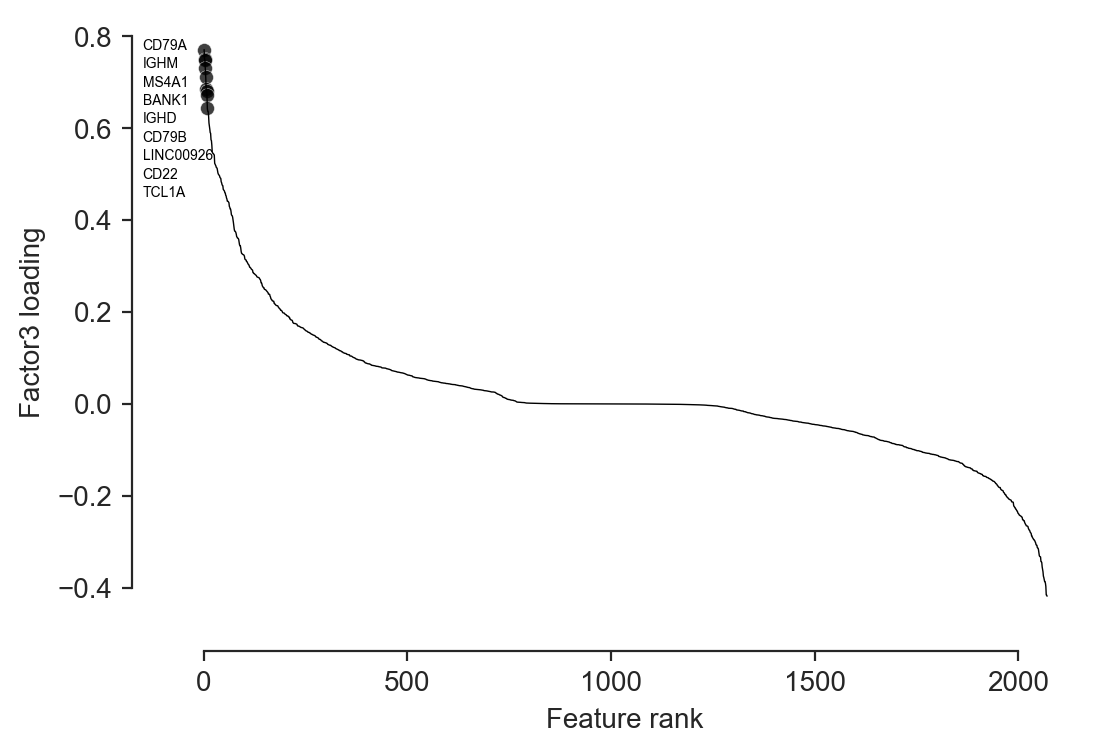

In [8]:
ax = mfx.plot_weights(m, factor=2, n_features=10,
                      y_repel_coef=0.04, x_rank_offset=-150)
# repel coefficient and offsets can be useful to move labels around
# and there are x_rank_offset and x_rank_offset_neg for positive and negative weights respectively

This factor is apparently a B cell-related factor (CD79, CD20 encoded by MS4A1 gene), most probably naïve B cells.

### Customising weights plots

Plots can be further customised using the axis object that is return by plotting functions.

Text(0.5, 1.0, 'B cells factor')

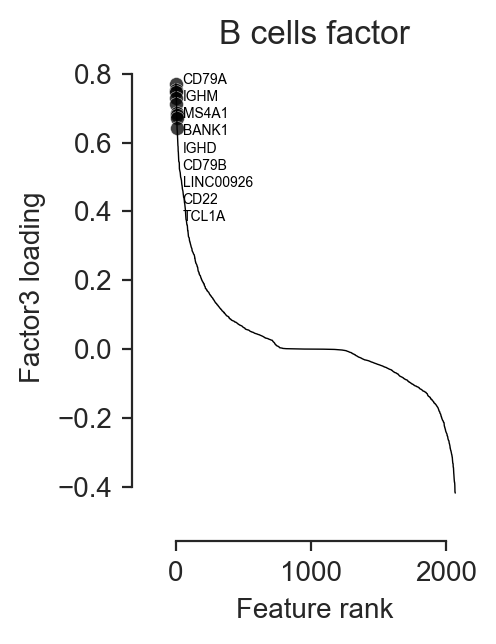

In [9]:
plt.figure(figsize=(2,3))
ax = mfx.plot_weights(m, factor=2, n_features=10,
                      y_repel_coef=0.05, x_rank_offset=50)
ax.set_title("B cells factor")

### Making subplots

When making plots for multiple factors, subplots can be used and an axis can be provided to the `plot_weights` call:

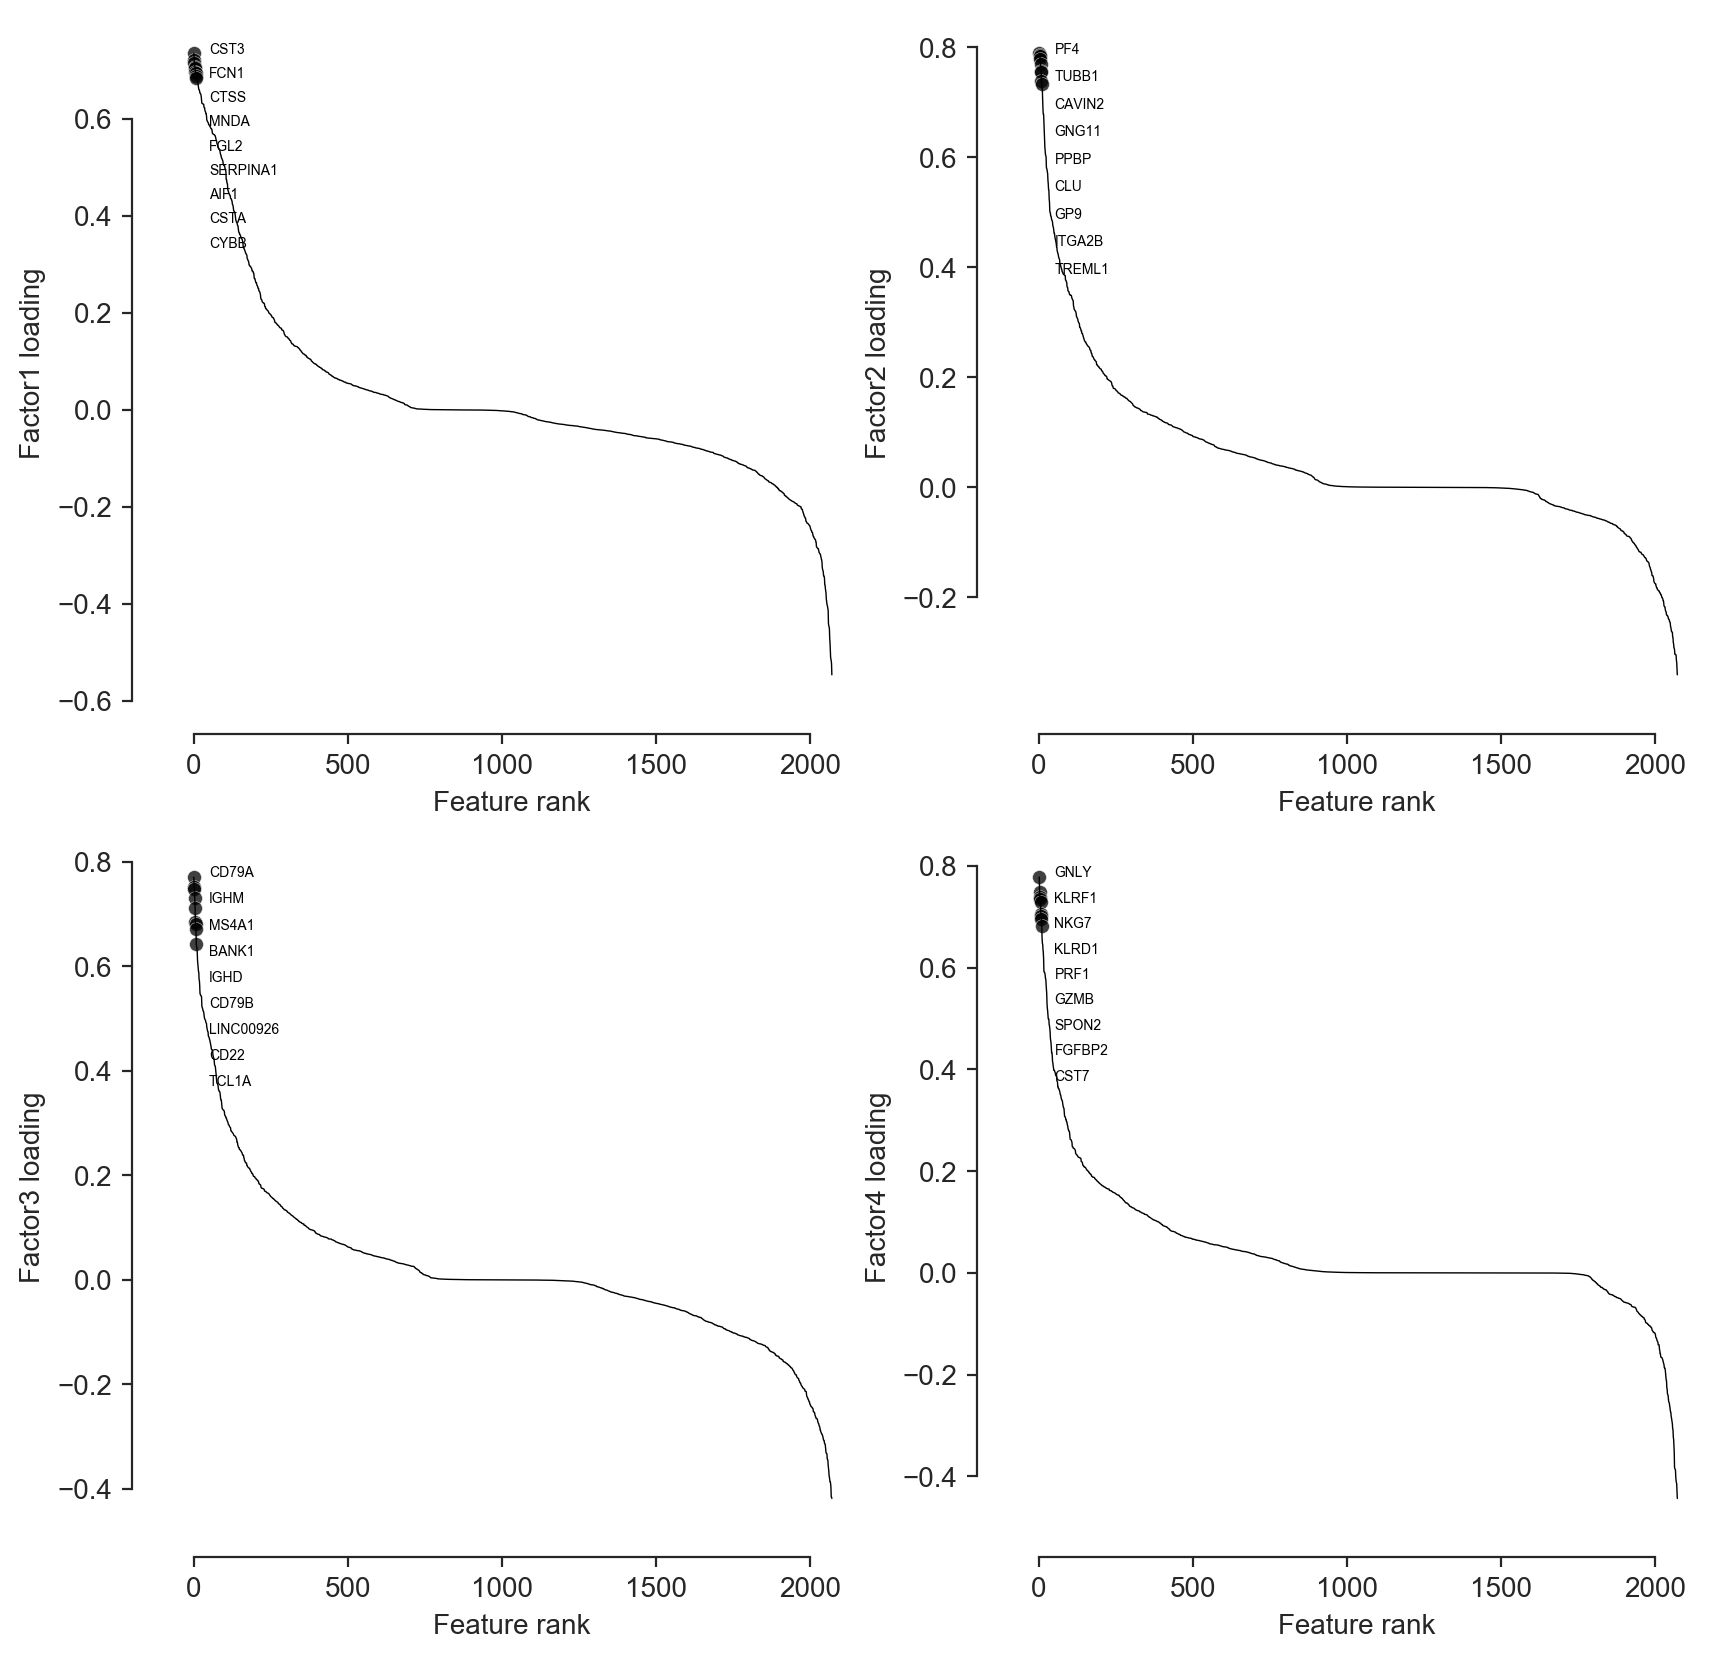

In [10]:
nf = 2  # specify number of rows & columns
f, axarr = plt.subplots(nf, nf, figsize=(10,10))
fnum = 0
for i in range(nf):
    for j in range(nf):
        mfx.plot_weights(m, 
                         # The trick here is to make a plot using a particular axis
                         factor=fnum, ax=axarr[i][j], 
                         n_features=10, x_rank_offset=50,
                         y_repel_coef=0.05, attract_to_points=False)
        fnum+=1

## Scaled weights scatterplot

The `plot_weights_scaled` function provides a quick way to plot loadings for 2 factors on one plot. This is one of the common ways of visualizing components/factors loadings in models such as PCA or factor models

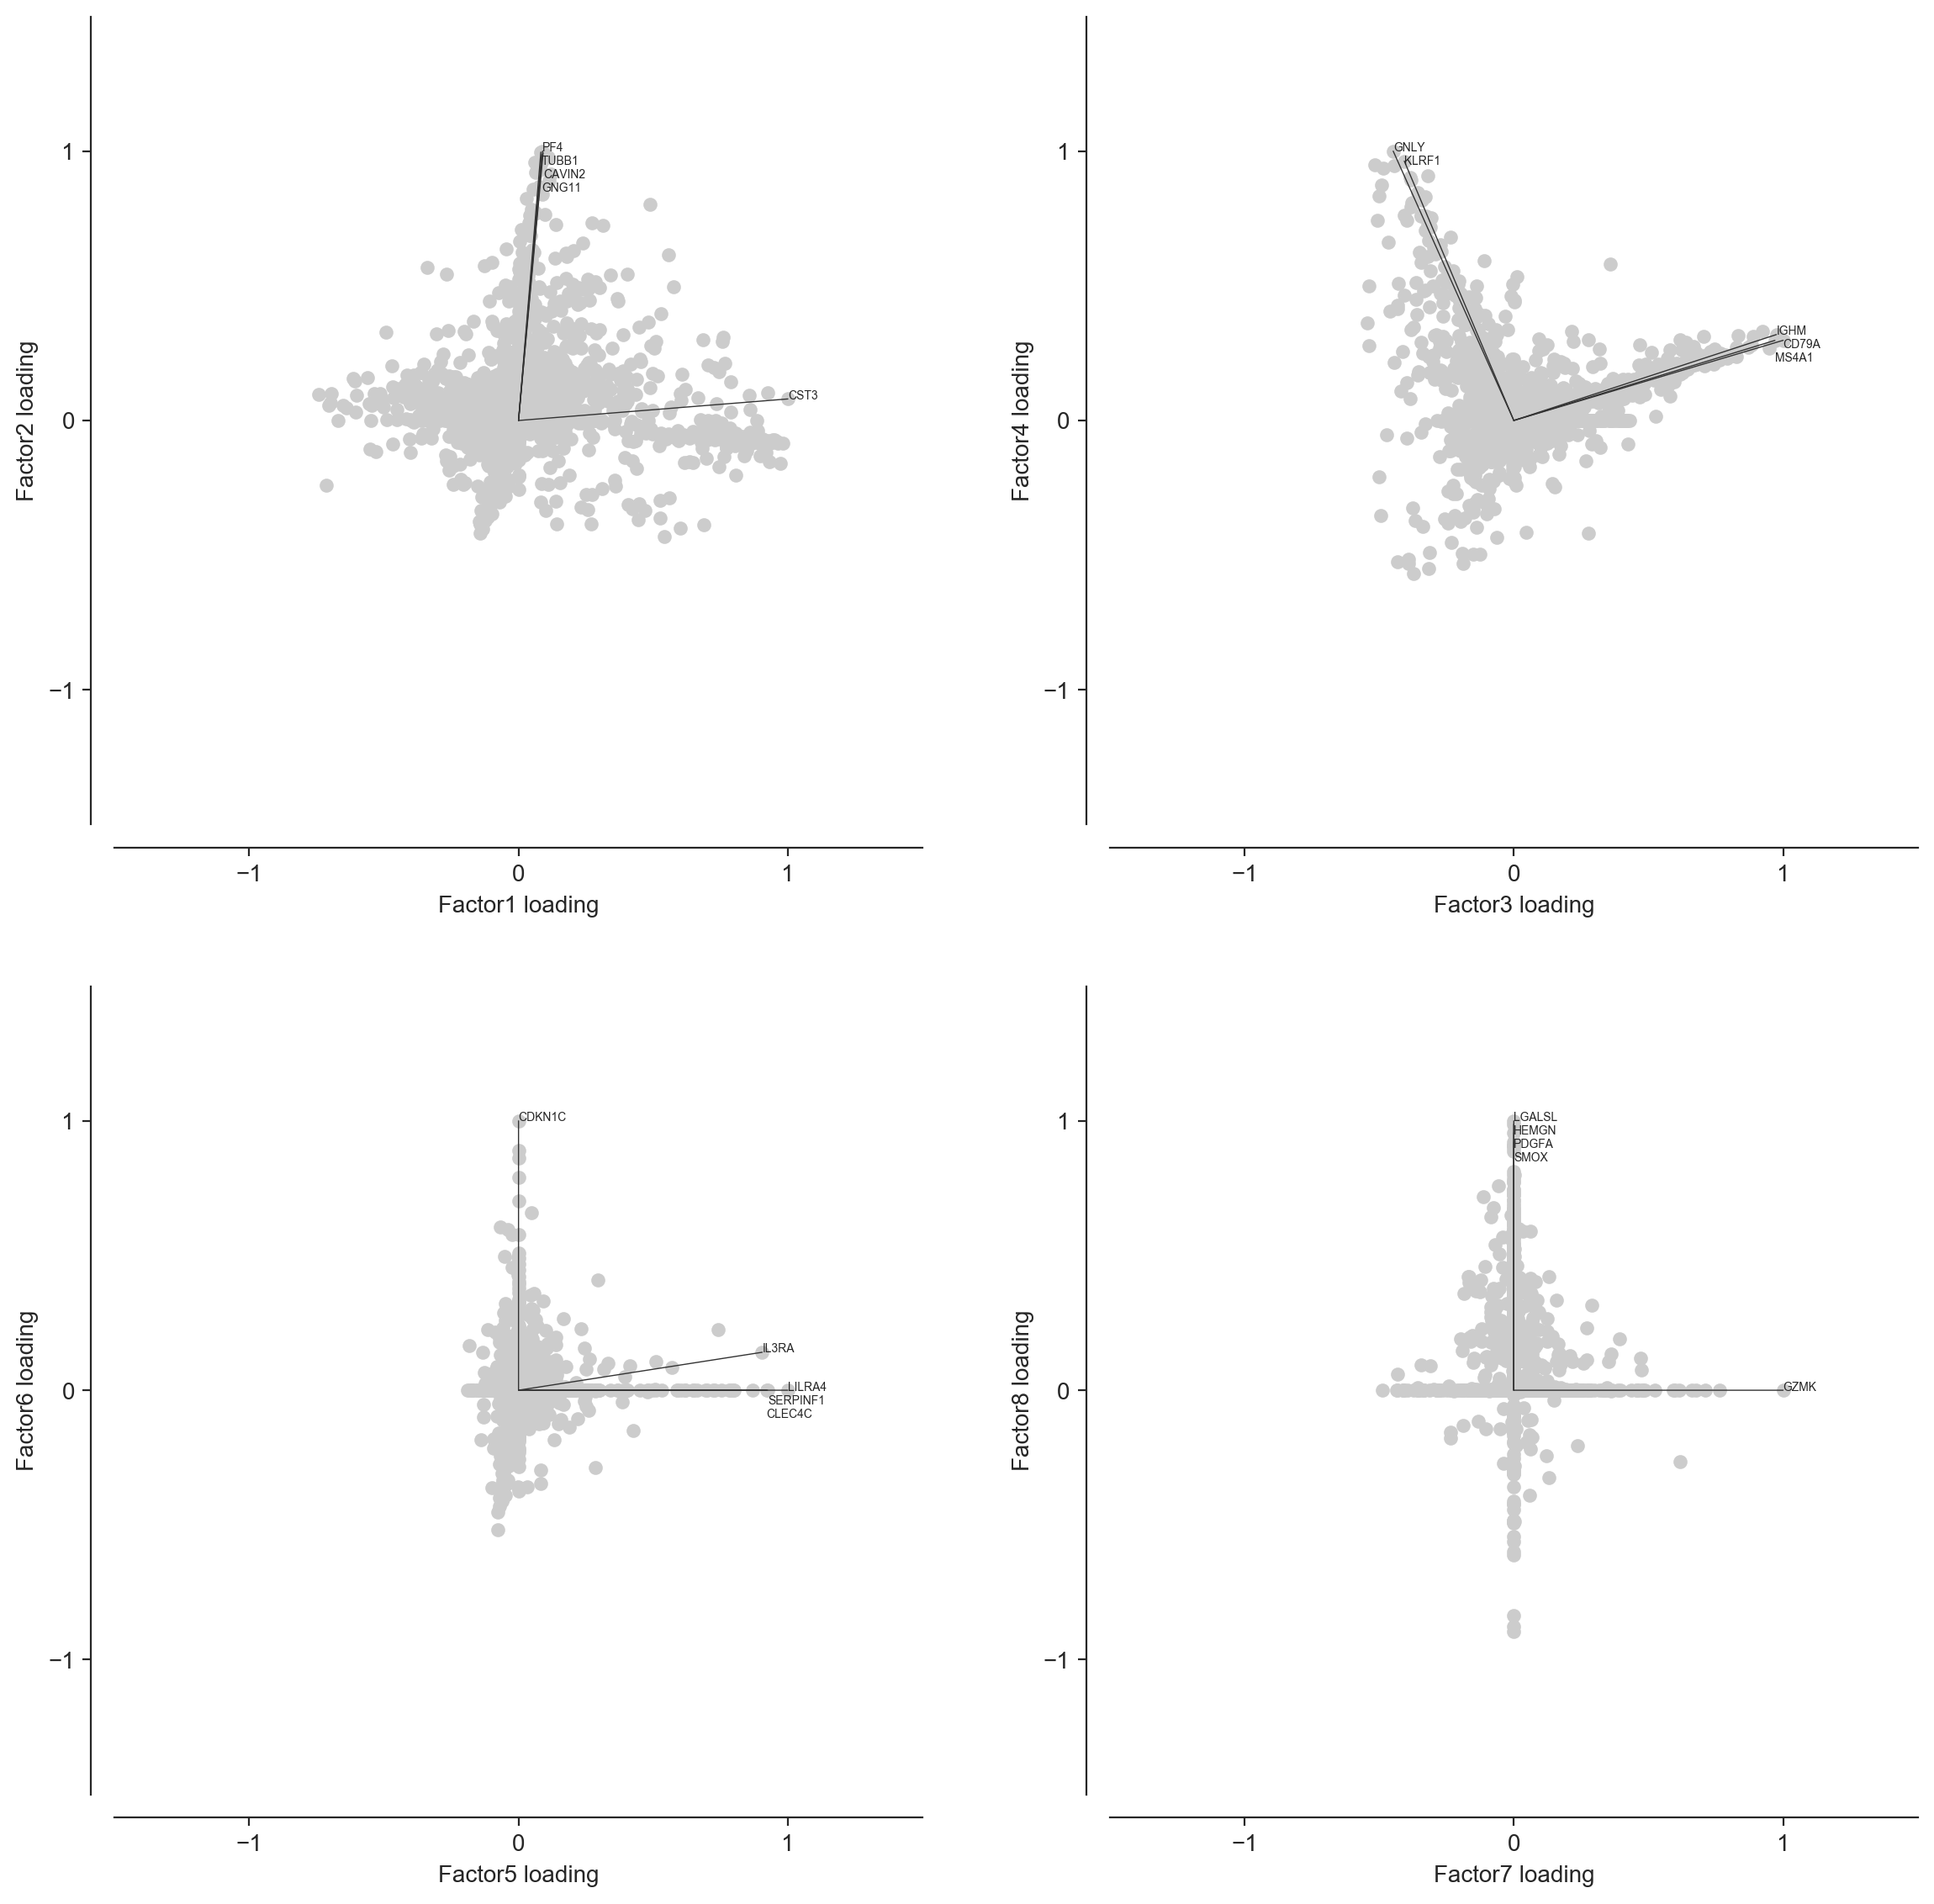

In [11]:
nf = 2
f, axarr = plt.subplots(nf, nf, figsize=(14,14))
fnum = 0
for i in range(nf):
    for j in range(nf):
        mfx.plot_weights_scaled(m, x=fnum, y=fnum+1, n_features=5,
                                ax=axarr[i][j])
        fnum+=2

## Weights scatterplot with marginal

If absolute loadings values are of interest, they can be compared between multiple factors with `plot_weights_scatter`. Marginal distributions can be added with `hist=True` or with `kde=True`.

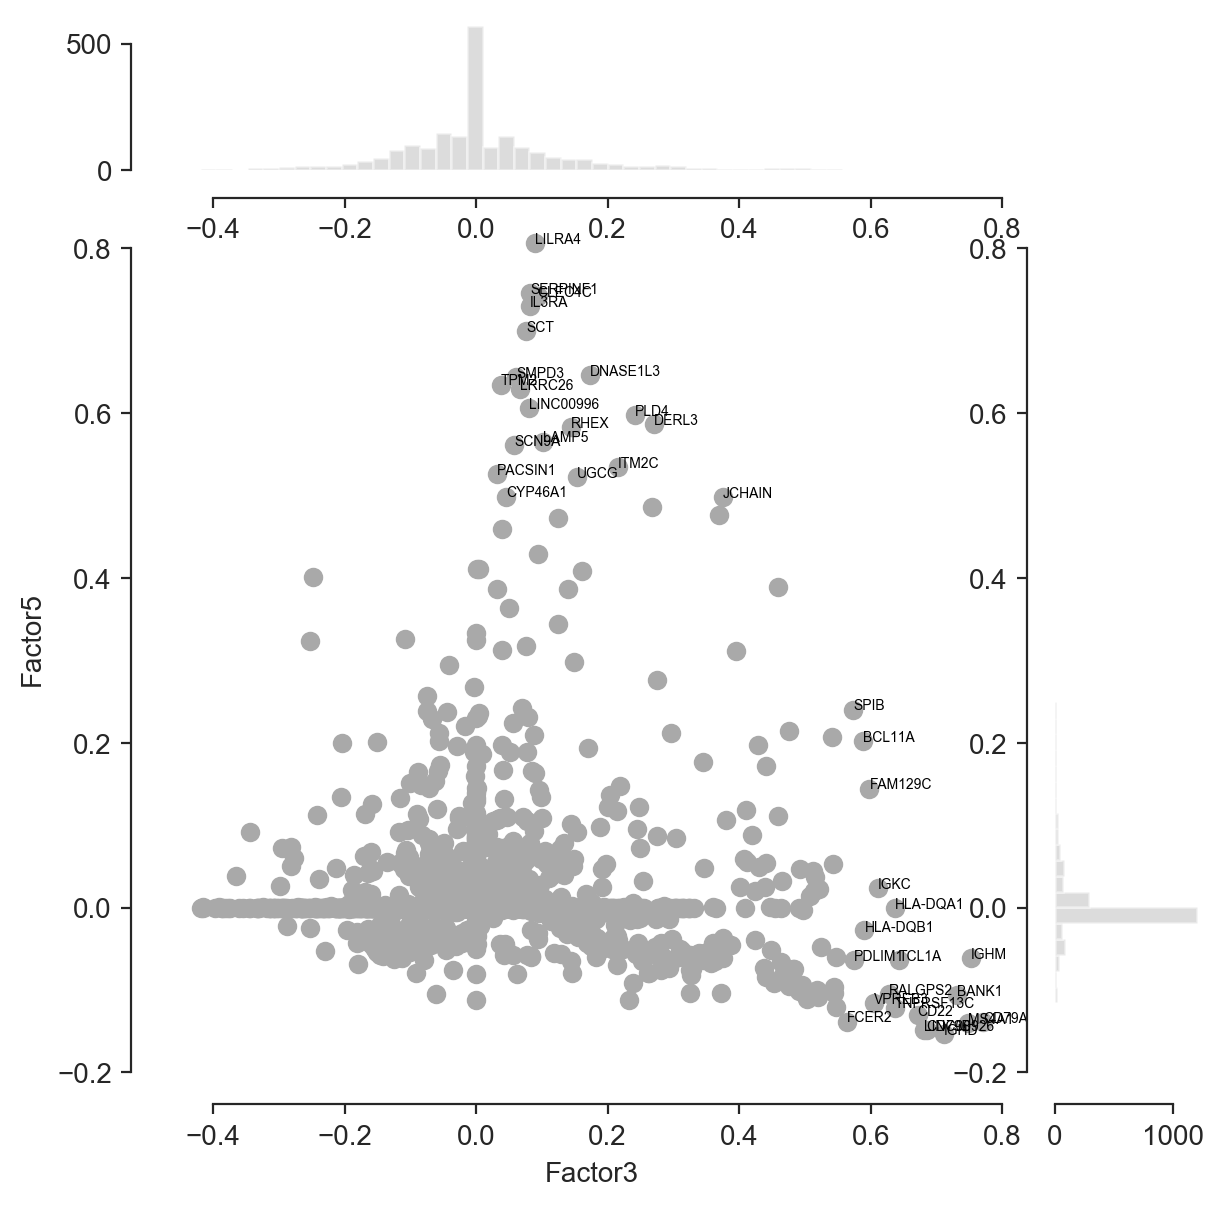

In [12]:
mfx.plot_weights_scatter(m, x="Factor3", y="Factor5",
                         hist=True, n_features=20)

## Weights heatmap

While trying to annotate factors, a global overview of top features defining them could be helpful. 

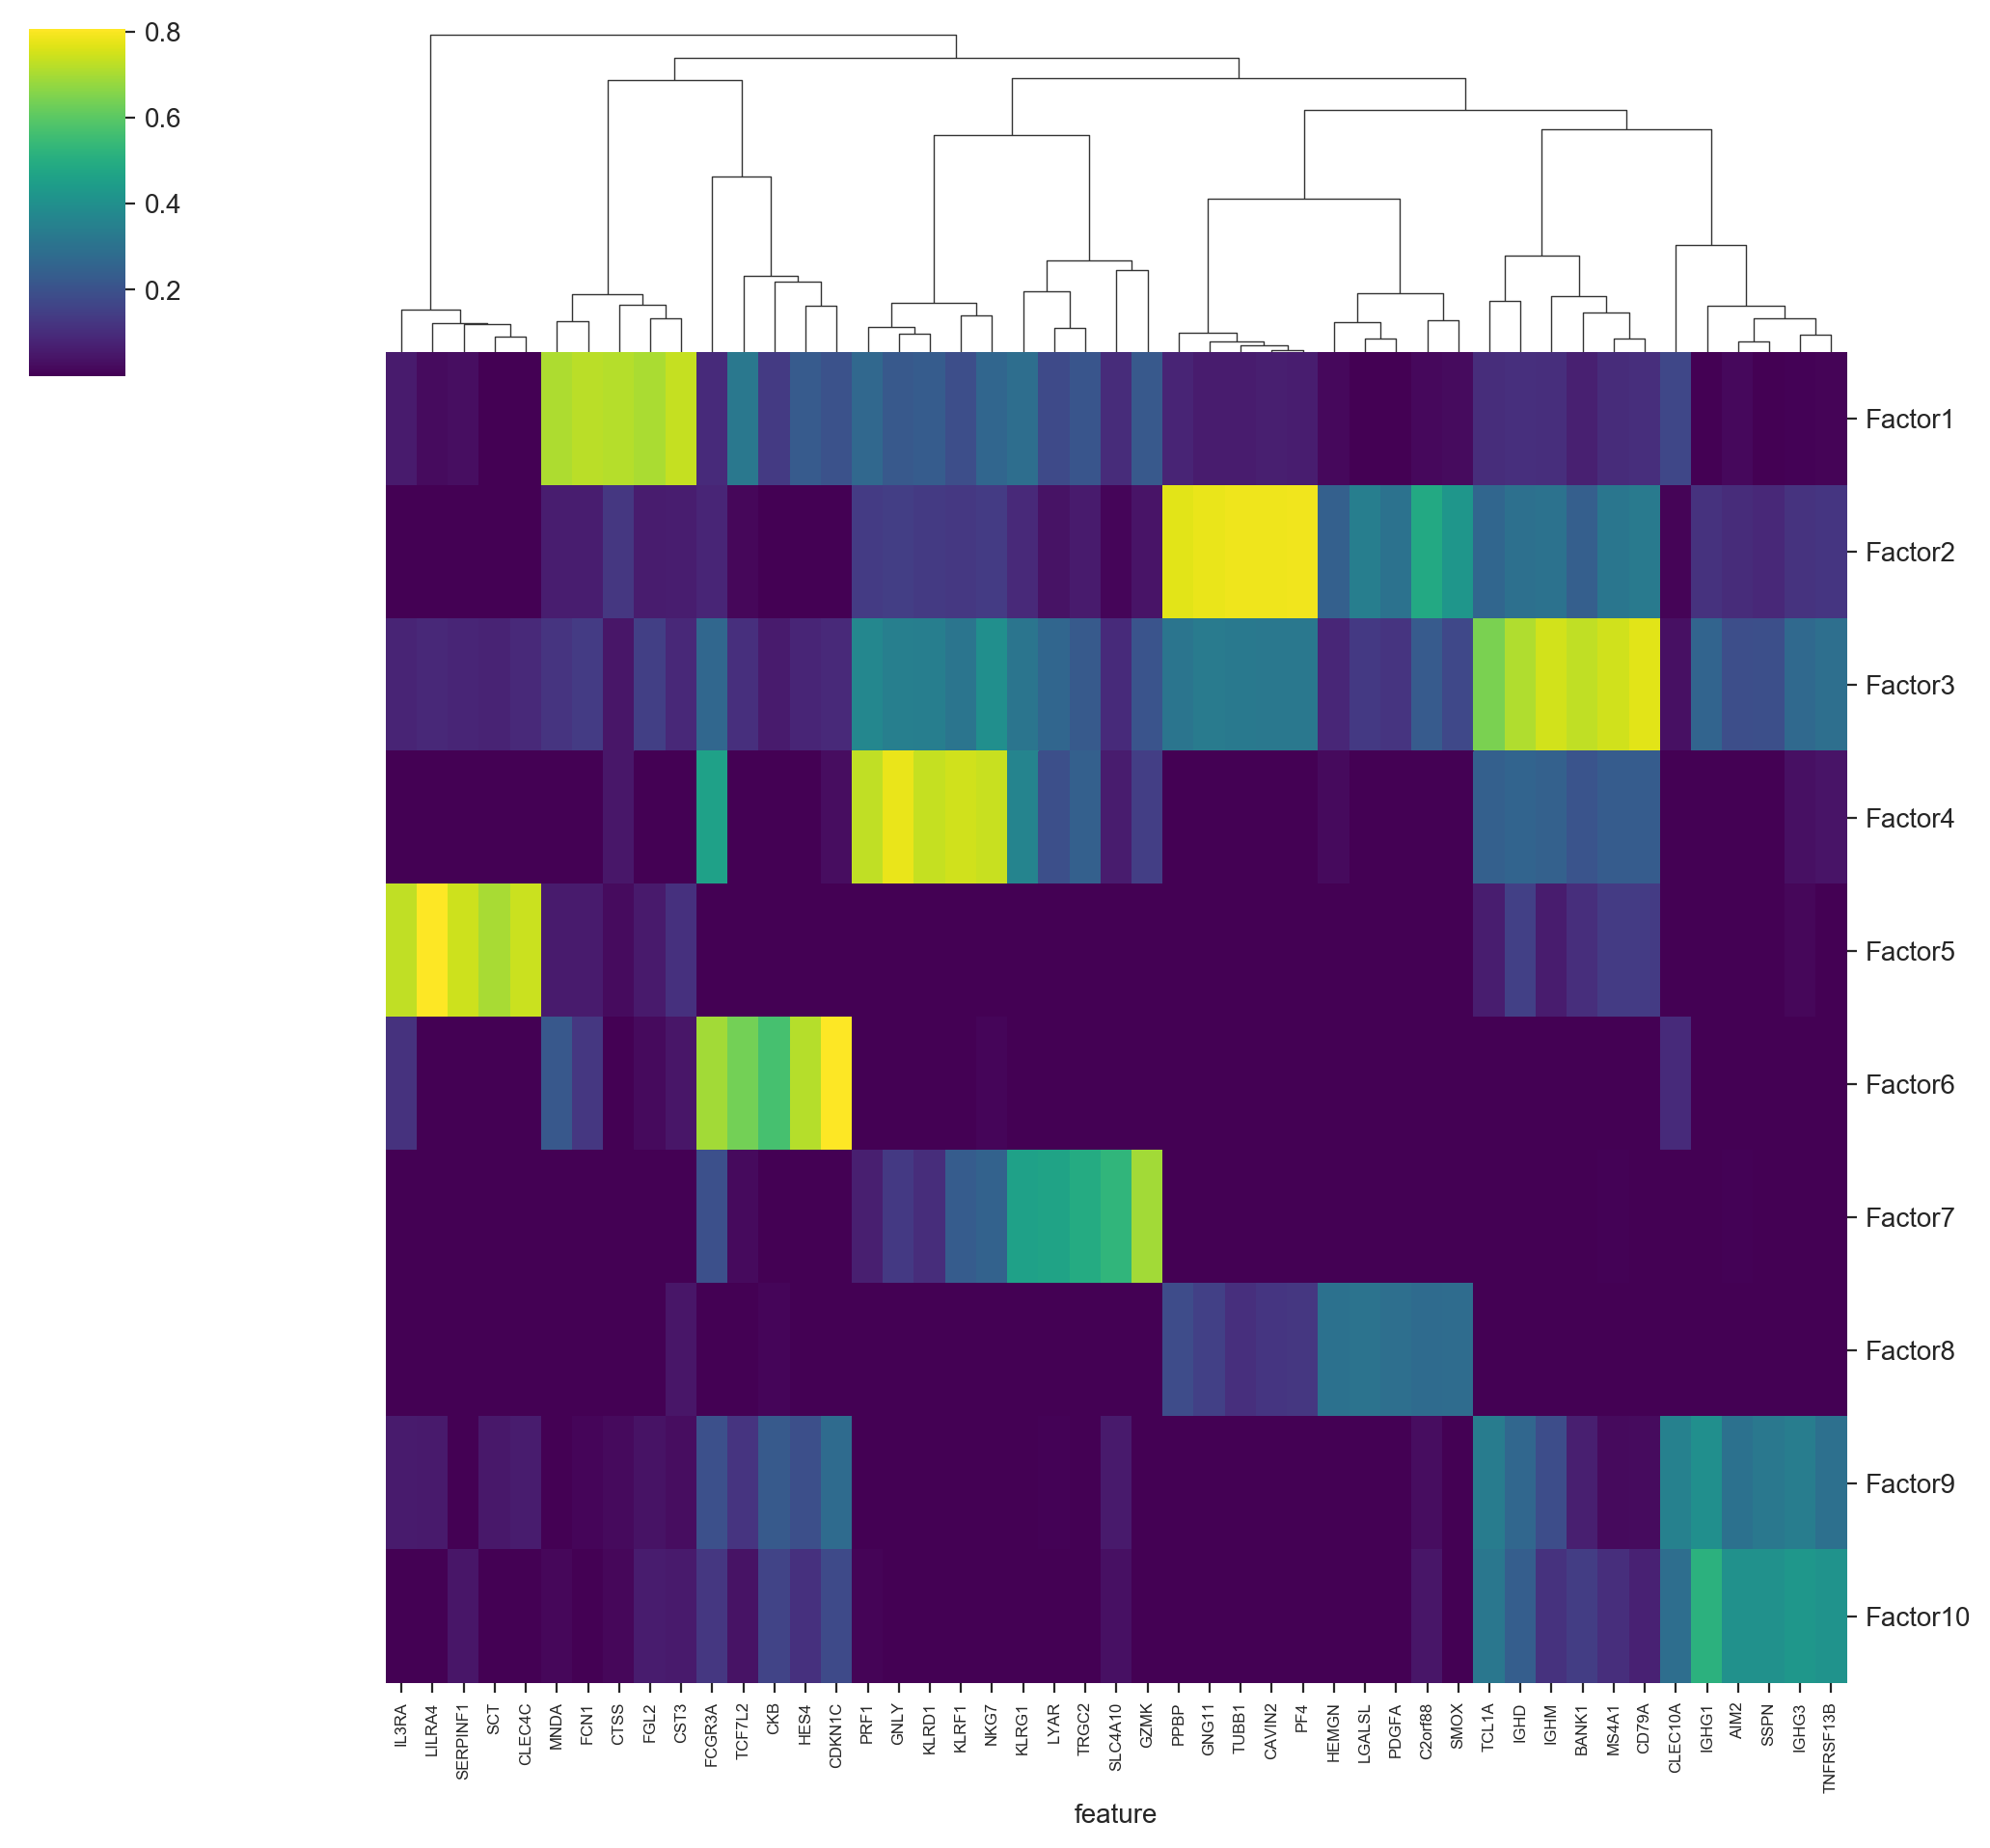

In [13]:
mfx.plot_weights_heatmap(m, n_features=5, 
                         factors=range(0, 10), 
                         xticklabels_size=6, w_abs=True, 
                         cmap="viridis", cluster_factors=False)

Features play a key role on this plot, and to put more emphasis on different types of features (e.g. different cell type markers), each feature can be coloured according to some pattern. E.g. We'll mark Ig genes on that heatmap

In [14]:
features_all = m.get_weights(df=True).index.values
ig_col = ['#007788' if i.startswith("IG") else '#DDDDDD' for i in features_all]
ig_df = pd.DataFrame({"feature": features_all, 
                       "value": ig_col}).set_index('feature')

ig_df.sort_values("value").head(2)

,value
feature,
IGFBP3,#007788
IGHD,#007788


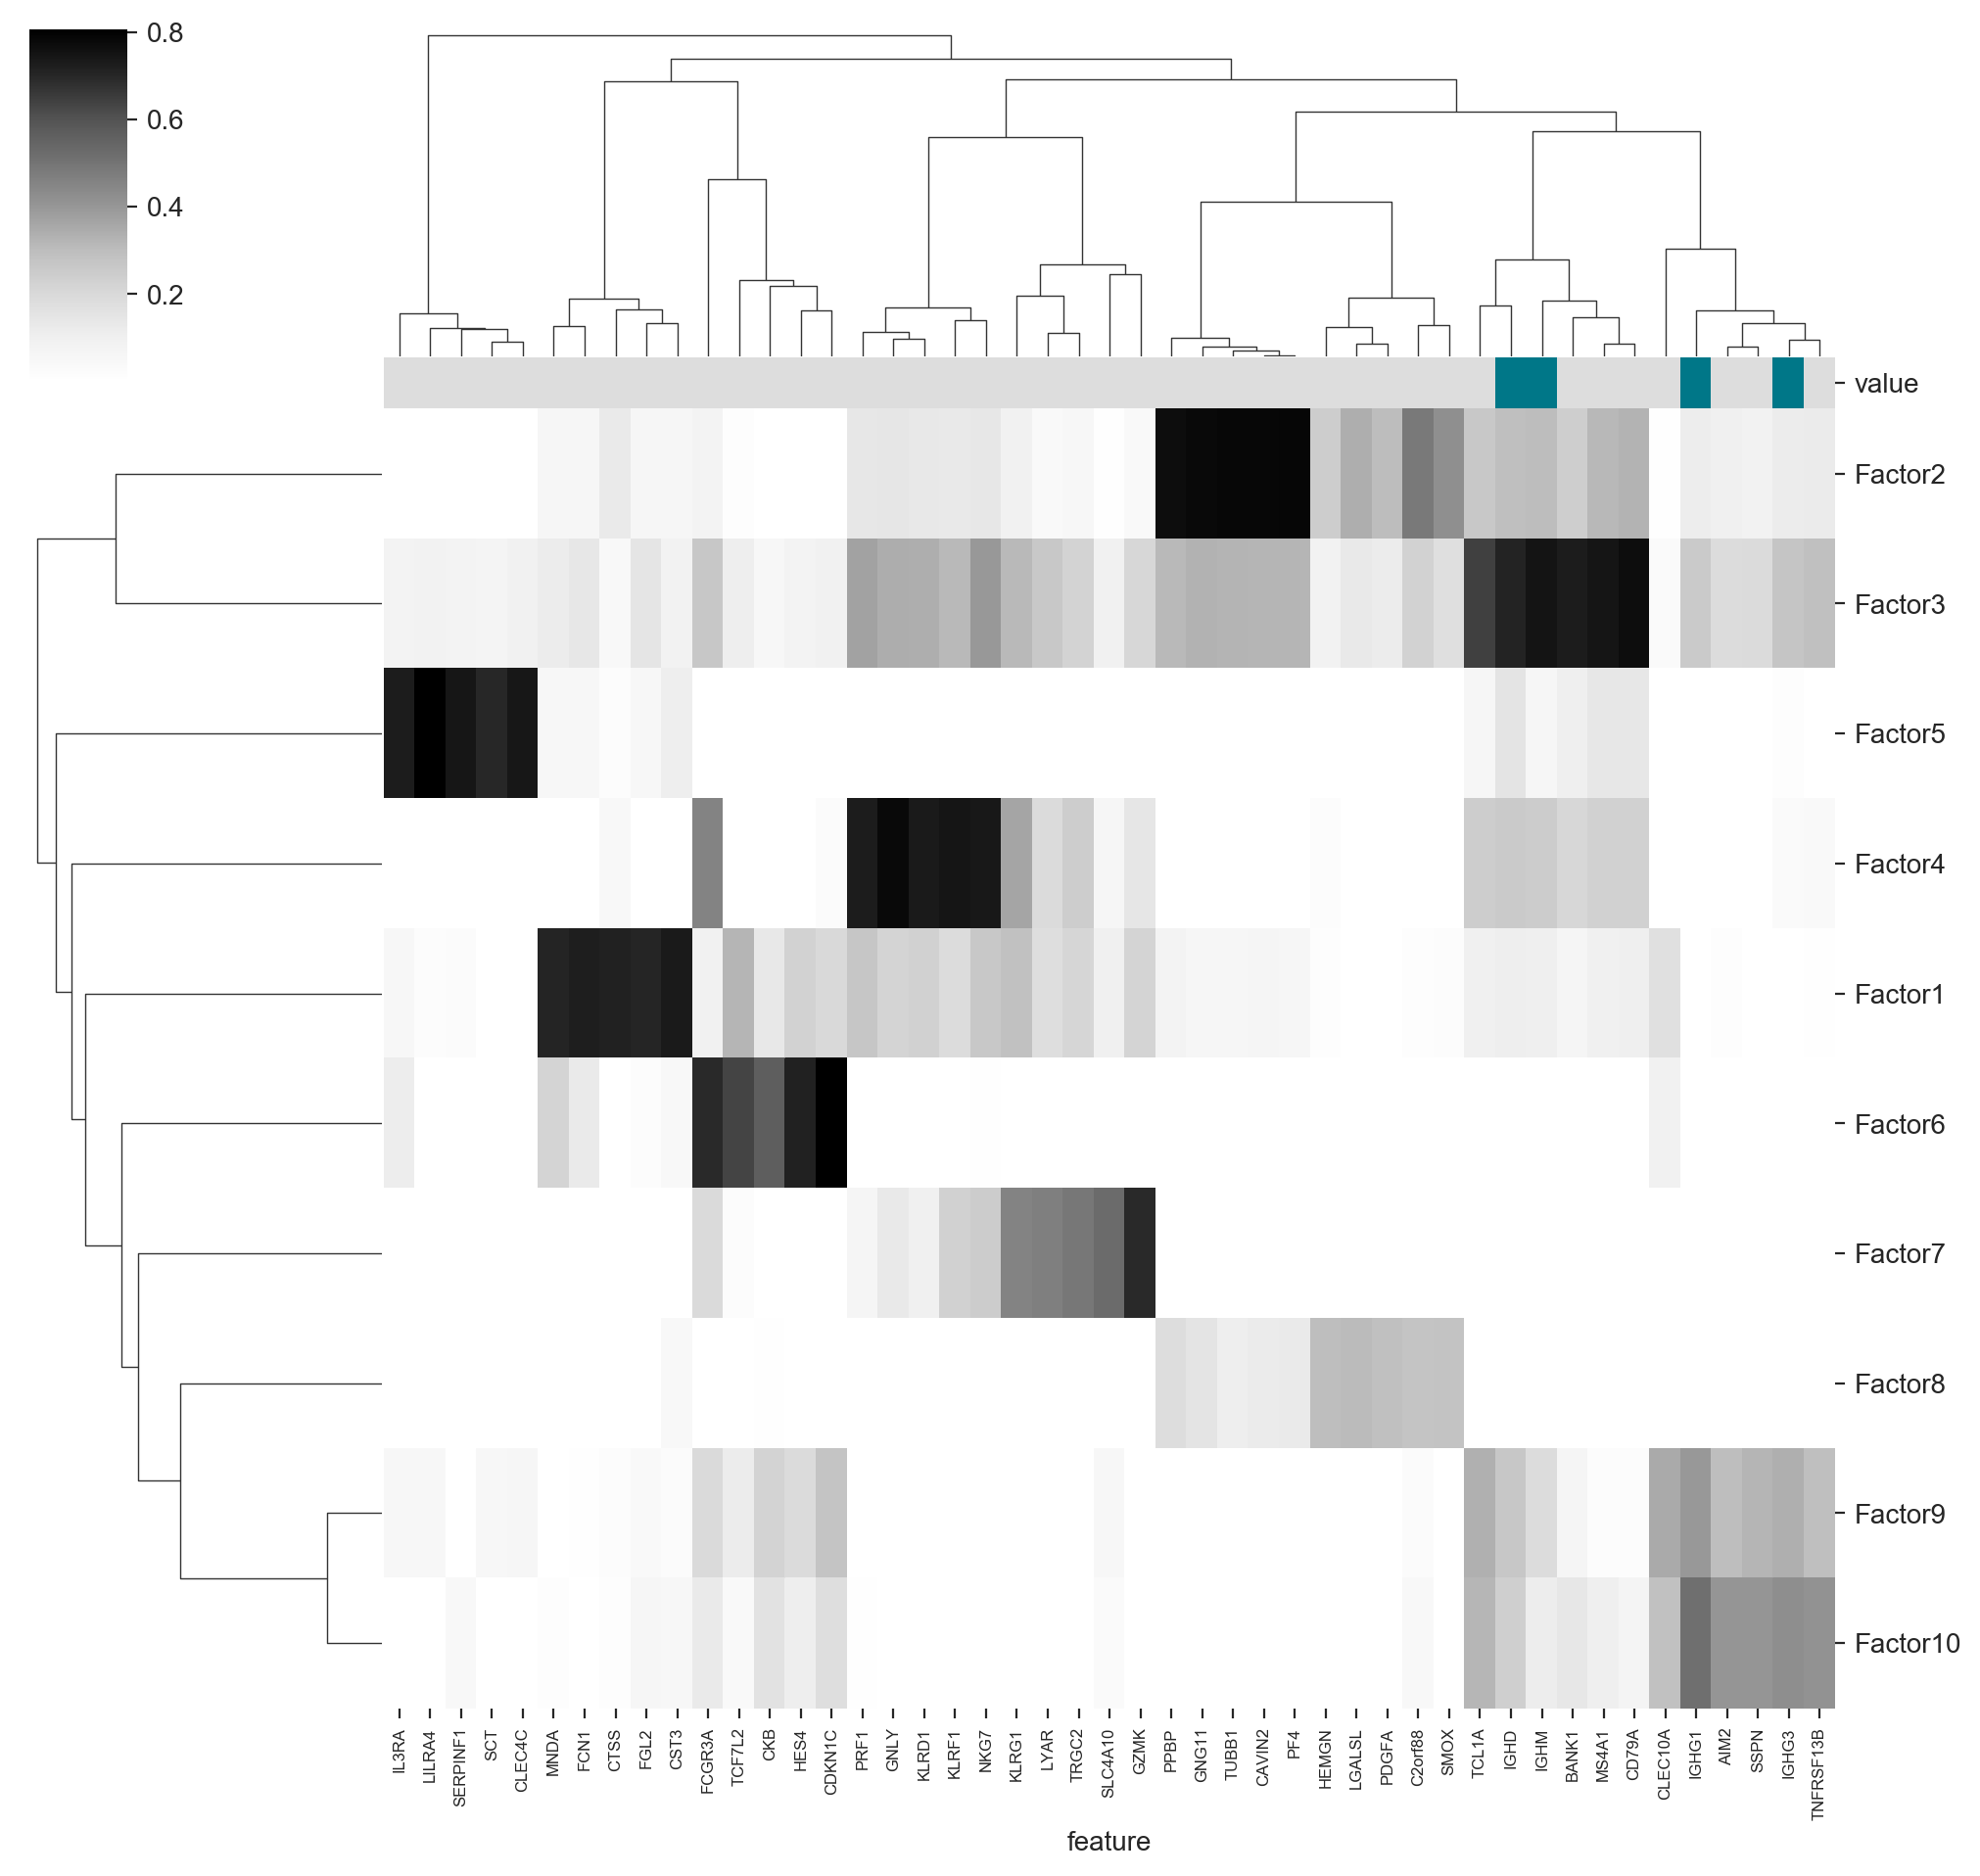

In [15]:
mfx.plot_weights_heatmap(m, n_features=5, 
                         factors=range(0, 10), 
                         features_col=ig_df,
                         xticklabels_size=6, w_abs=True, 
                         cmap="Greys")

## Weights dotplot

If one wants to rank top features across multiple factors and see how their loadings differ between factors (and how loadings for different features are different for one factor), a dotplot can be useful.

Both absolute loadings or signed ones can be plotted easily (use `w_abs` boolean flag for that).

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:733: UserWarning: Using the stripplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


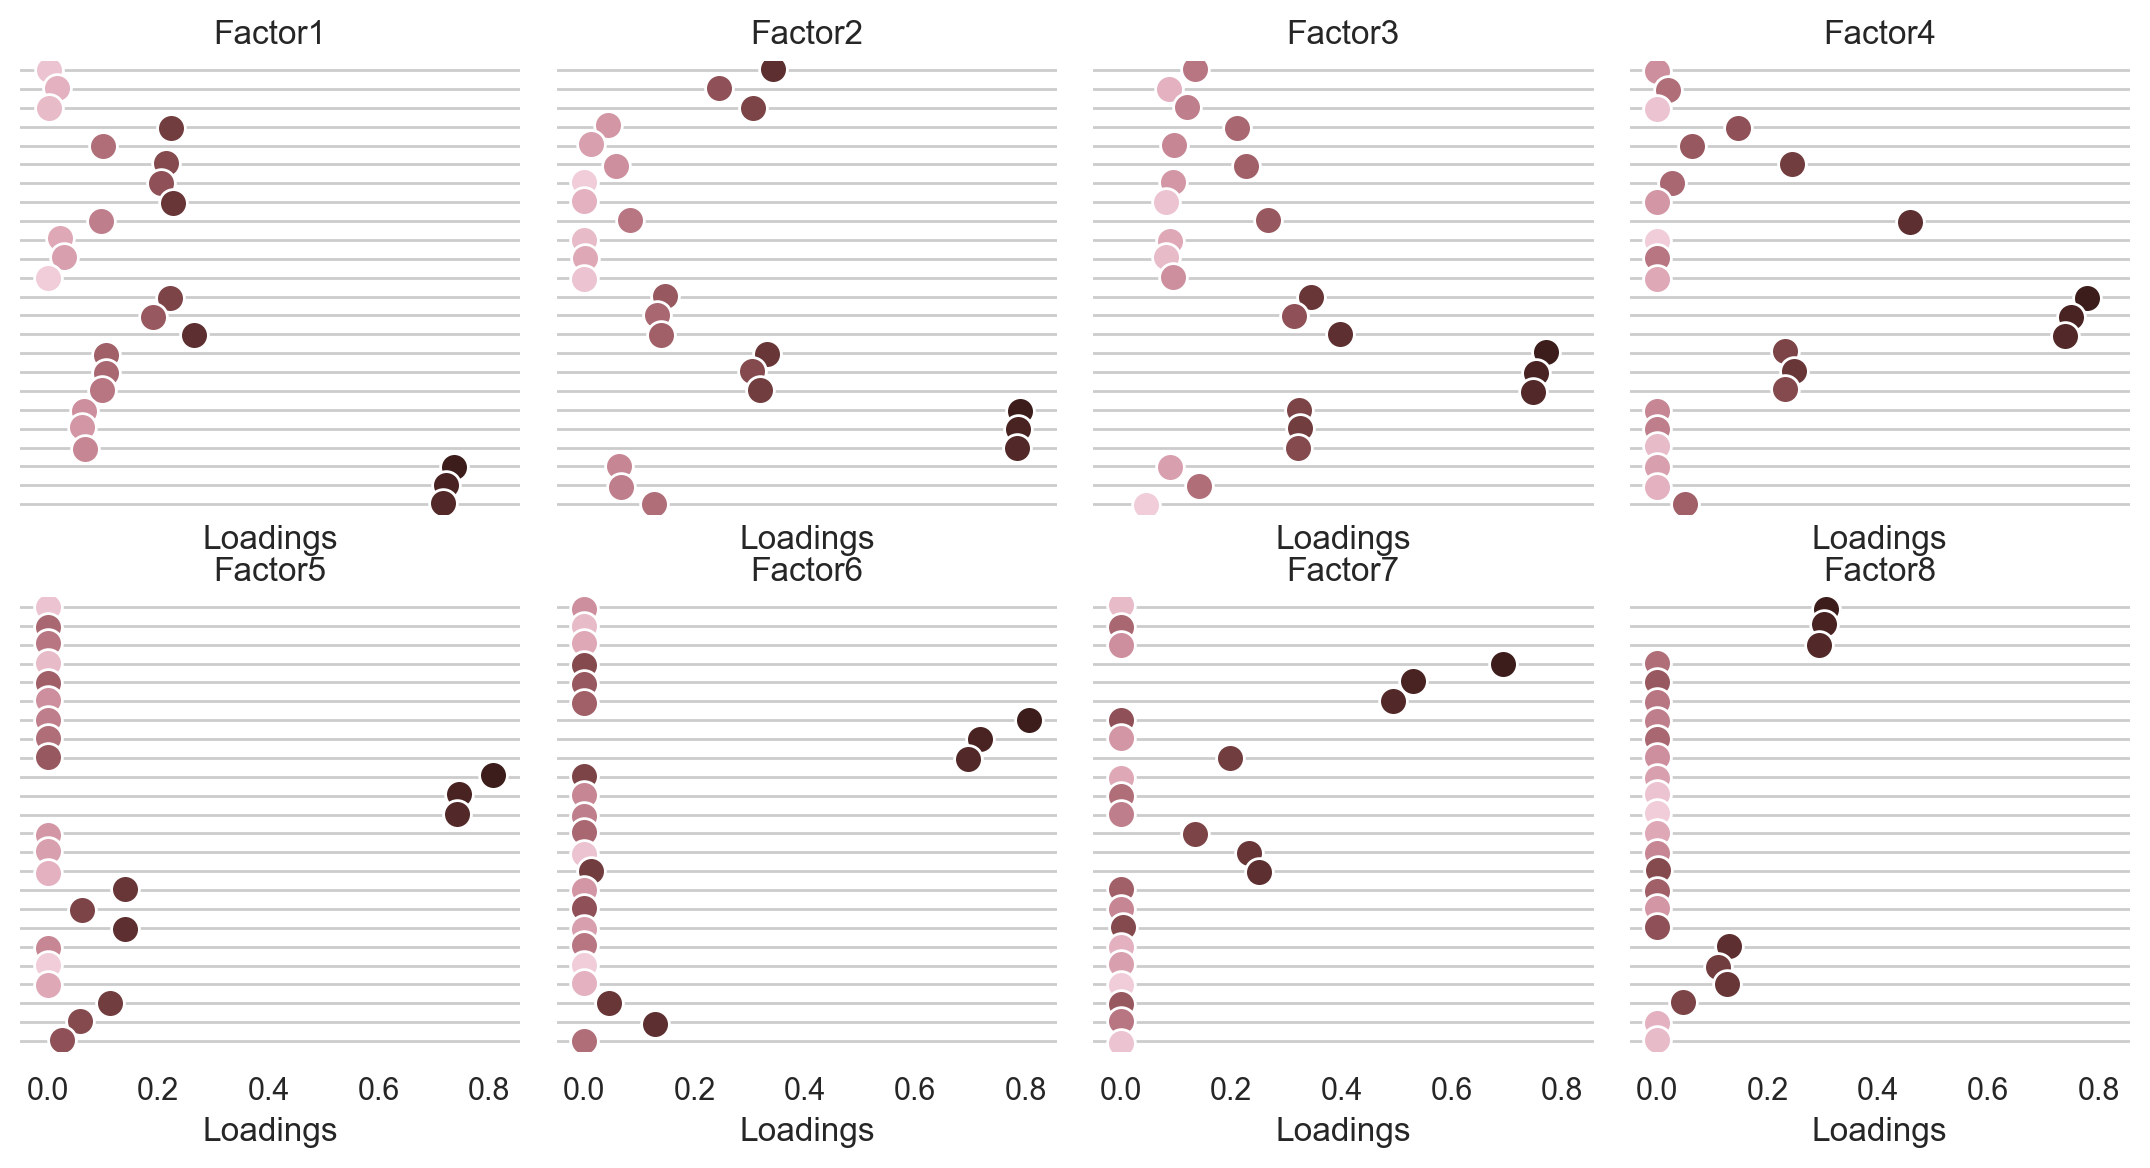

In [16]:
mfx.plot_weights_dotplot(m, n_features=3, 
                         w_abs=True, 
                         factors=list(range(8)), 
                         col_wrap=4, yticklabels_size=5)

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:733: UserWarning: Using the stripplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


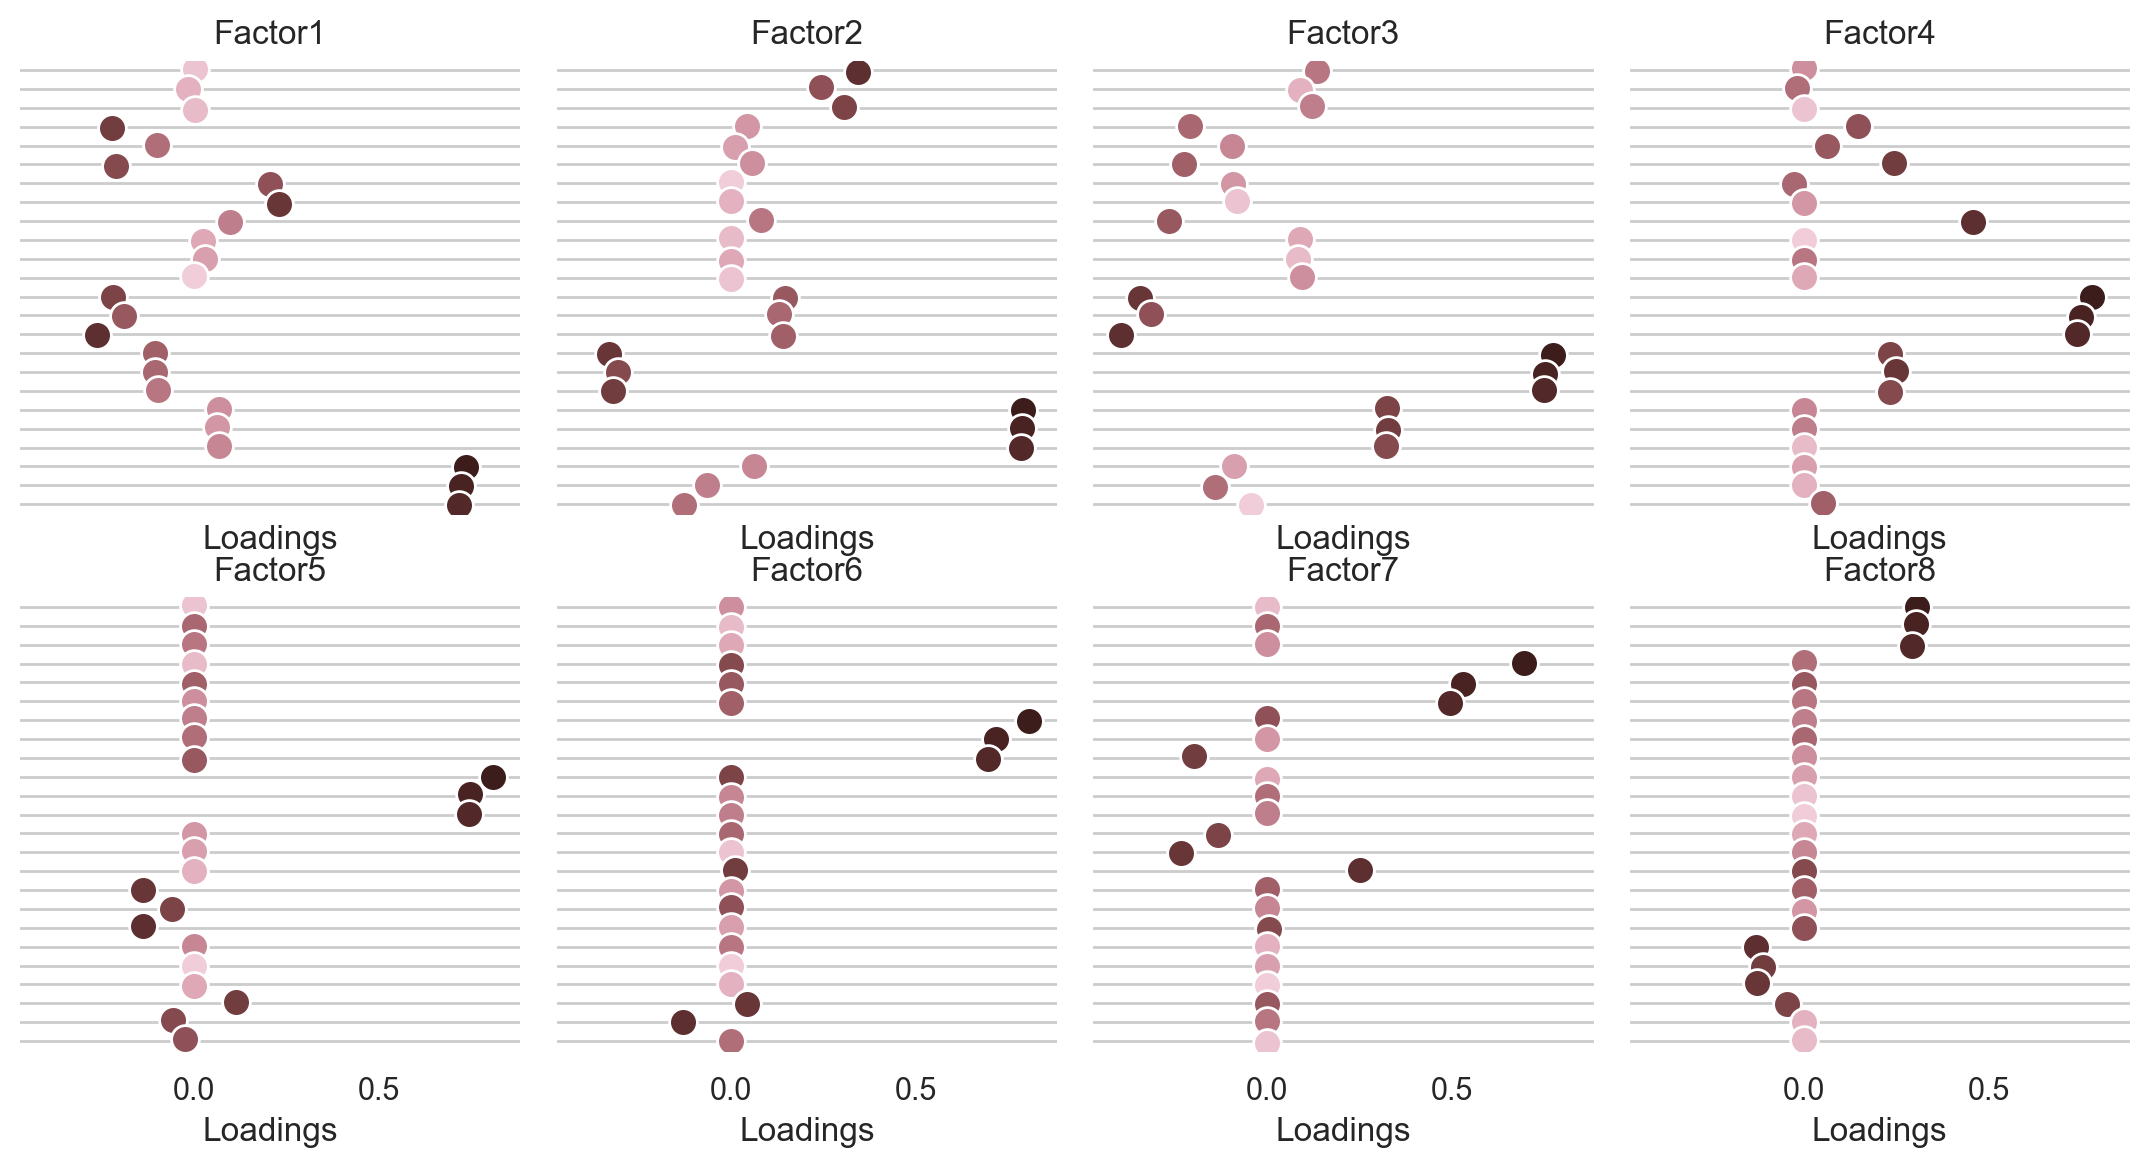

In [17]:
mfx.plot_weights_dotplot(m, n_features=3,  # Number of top features for every factor
                         w_abs=False, 
                         factors=list(range(8)), 
                         col_wrap=4, yticklabels_size=5)

In the latter case, i.e. when using original (not absolute) loadings values, it's easy to see which genes vary in different direction while being important for this factor, e.g. see Factor 8 above.

# Weights correlation

To compare factors defined by weights, a simple correlation could be useful. It is simple and might not suite analysis of complicated scenarios with _some_ weights being correlated, yet it is a useful overview on weights.

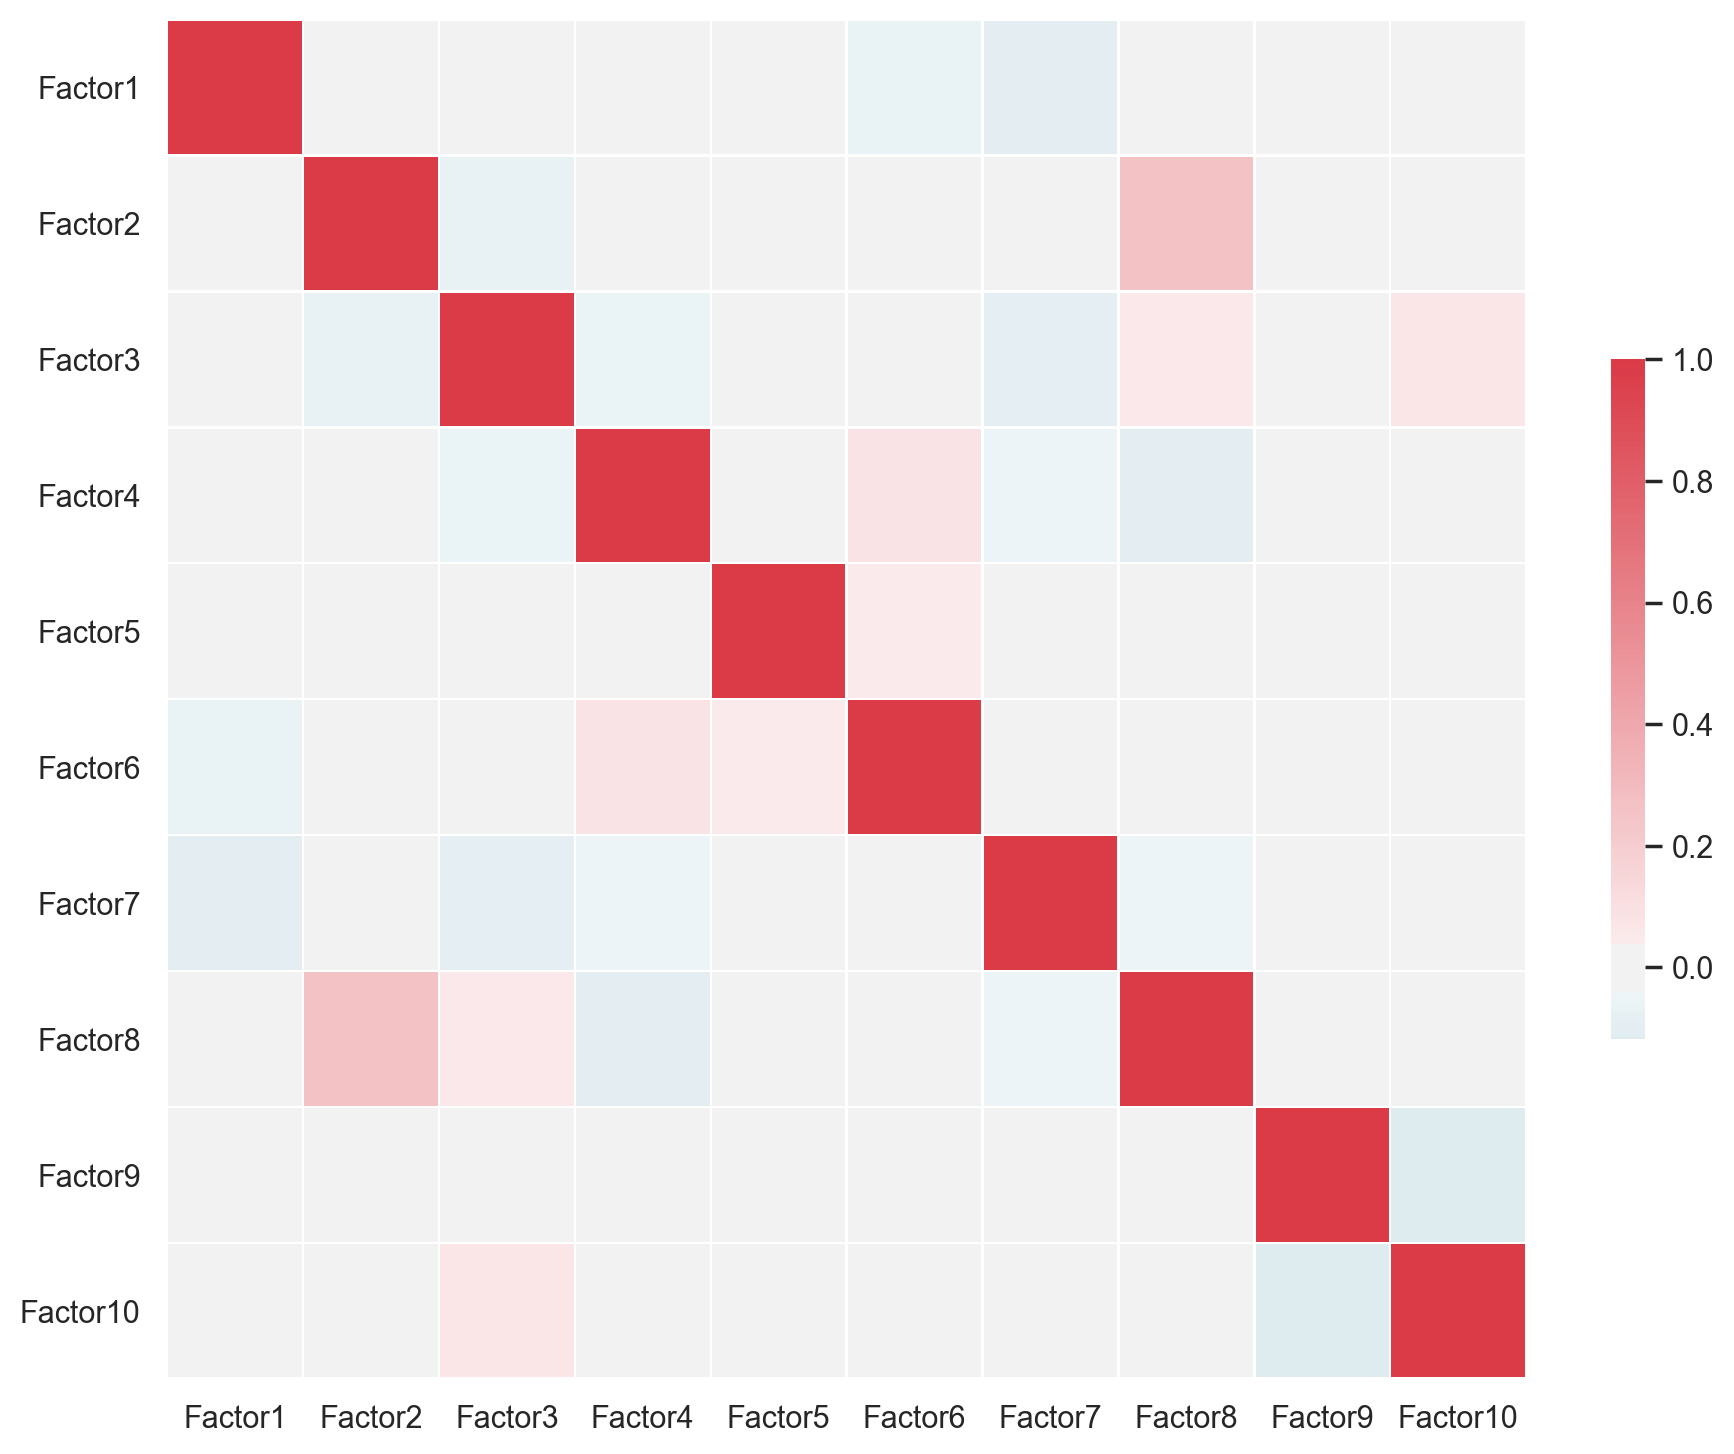

In [18]:
mfx.plot_weights_correlation(m)

# Variance explained

One of the key ways to investigate how different sources of variation (factors) very across different views (omics) and groups (groups of cells) is to reconstruct the features times cells matrix, one factor at a time, and to compare it with the original data.

There are the following `mofa_model` methods available to get this information:

- `get_factor_r2`,
- `get_r2`,

the latter being a wrapper around the former to get R2 values for multiple factors (all factors by default).

In [19]:
m.get_factor_r2(3).sort_values("R2", ascending=False)

,Factor,Group,R2,View
0,Factor4,group1,0.019148,rna


In [20]:
m.get_r2(factors=list(range(4))).sort_values("R2", ascending=False).head()

,Factor,View,Group,R2
0,Factor1,rna,group1,0.064007
1,Factor2,rna,group1,0.032982
2,Factor3,rna,group1,0.030091
3,Factor4,rna,group1,0.019148
4,Factor5,rna,group1,0.007797


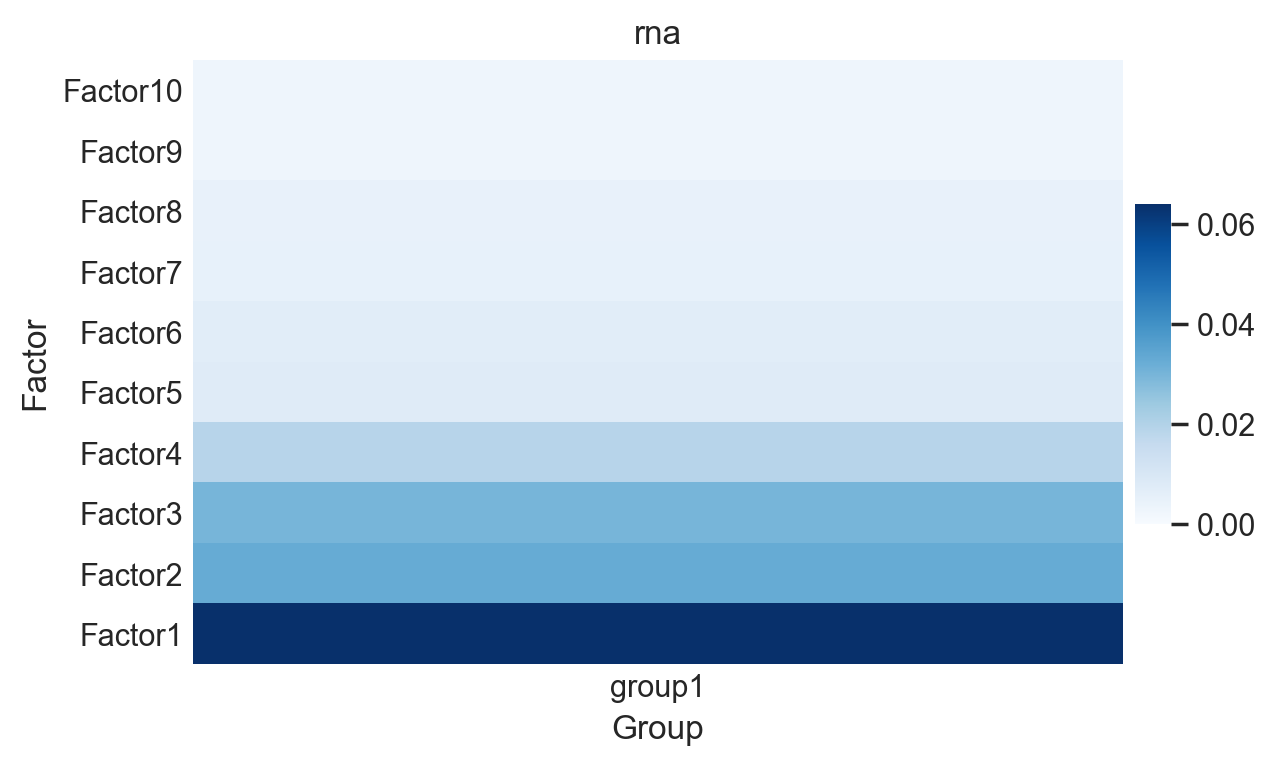

In [21]:
mfx.plot_r2(m, factors=list(range(10)), cmap="Blues")

Since having one group of cells is not particularly interesting for the variance explained plots so we can provide additional grouping to see if factors might correspond to those groups. E.g. let's load celltypes for this dataset:

In [22]:
celltypes = pd.read_csv("data/pbmc10k_celltypes.csv").set_index("cell")

In [23]:
# Add cell type information to the metadata
m.metadata = m.metadata.join(celltypes)

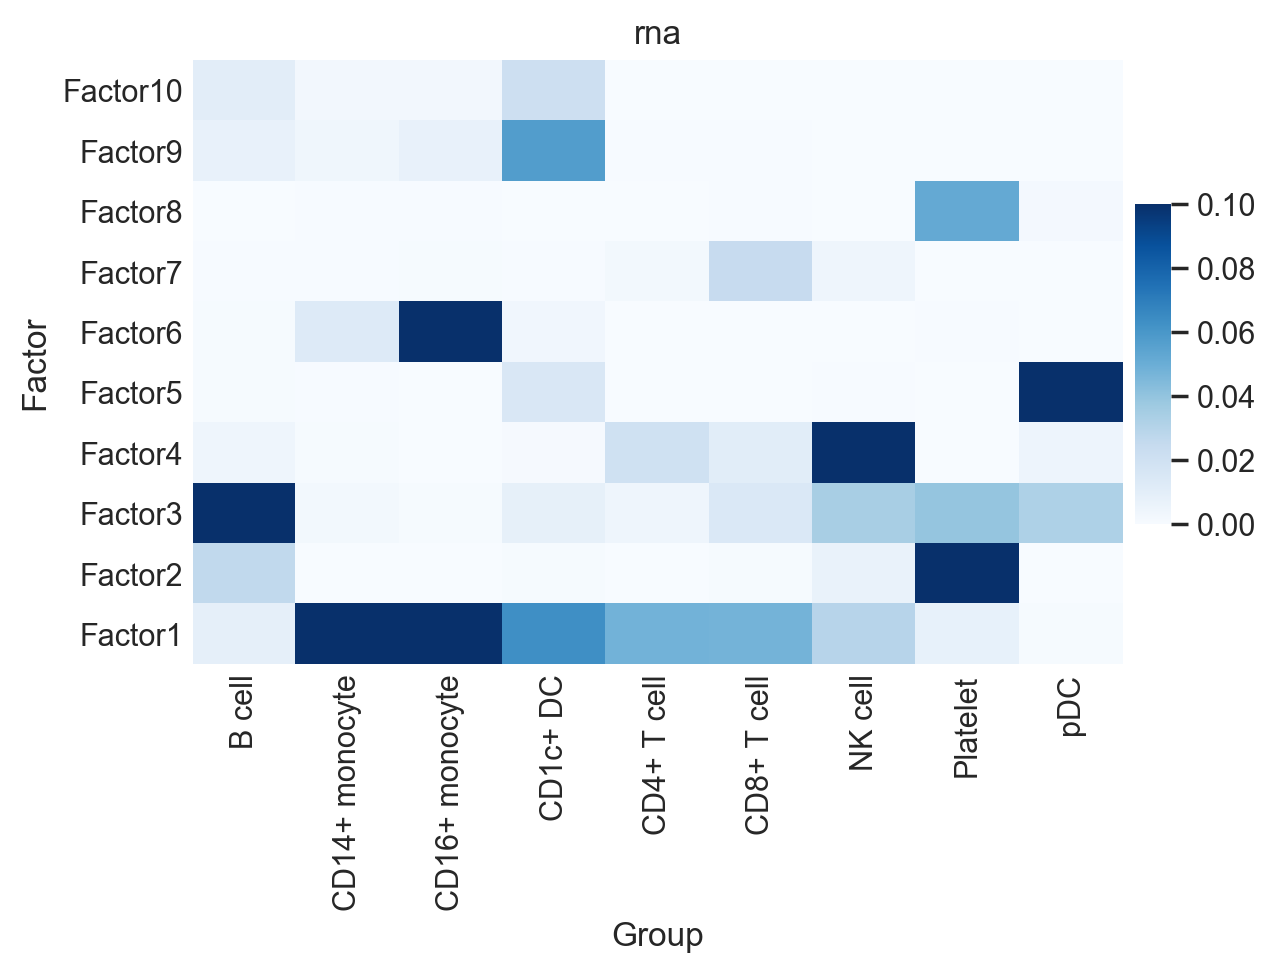

In [24]:
mfx.plot_r2(m, factors=list(range(10)), 
            cmap="Blues", vmax=.1, vmin=.0,
            group_label="celltype")

A barplot can be used in addition to the heatmap to better resolve R2 values for particular factors:

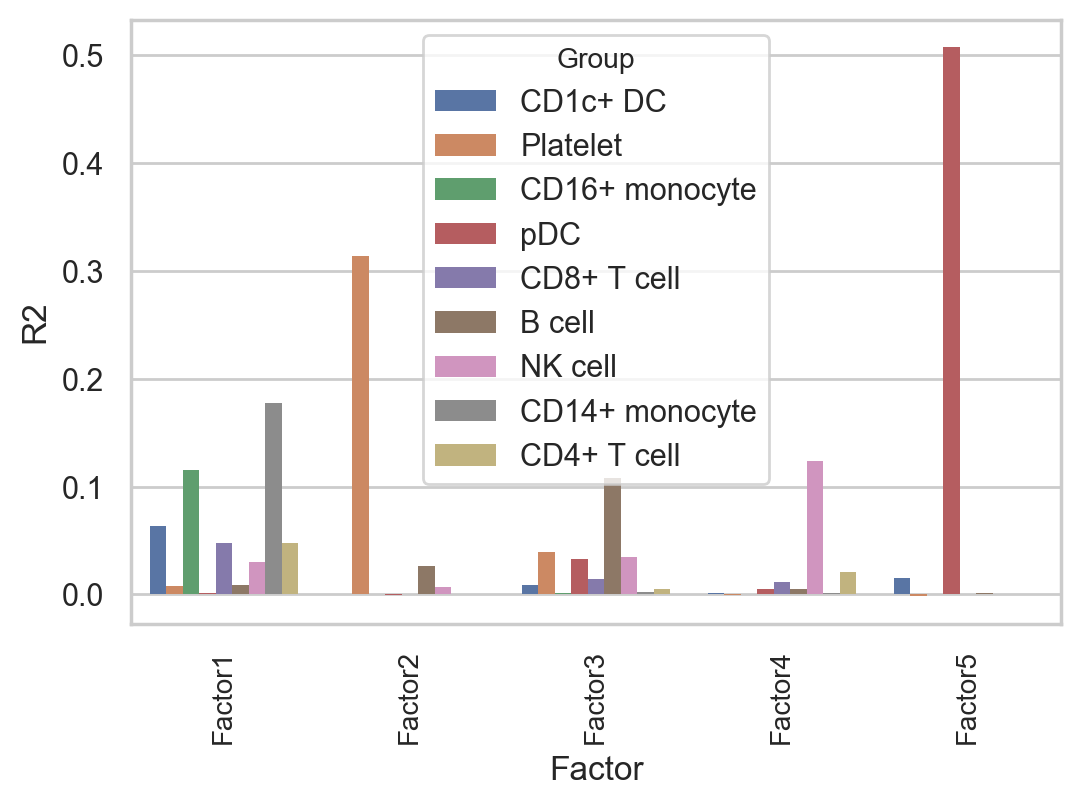

In [25]:
mfx.plot_r2_barplot(m, group_label="celltype", factors=list(range(5)))

It might be more clear to stack the values:

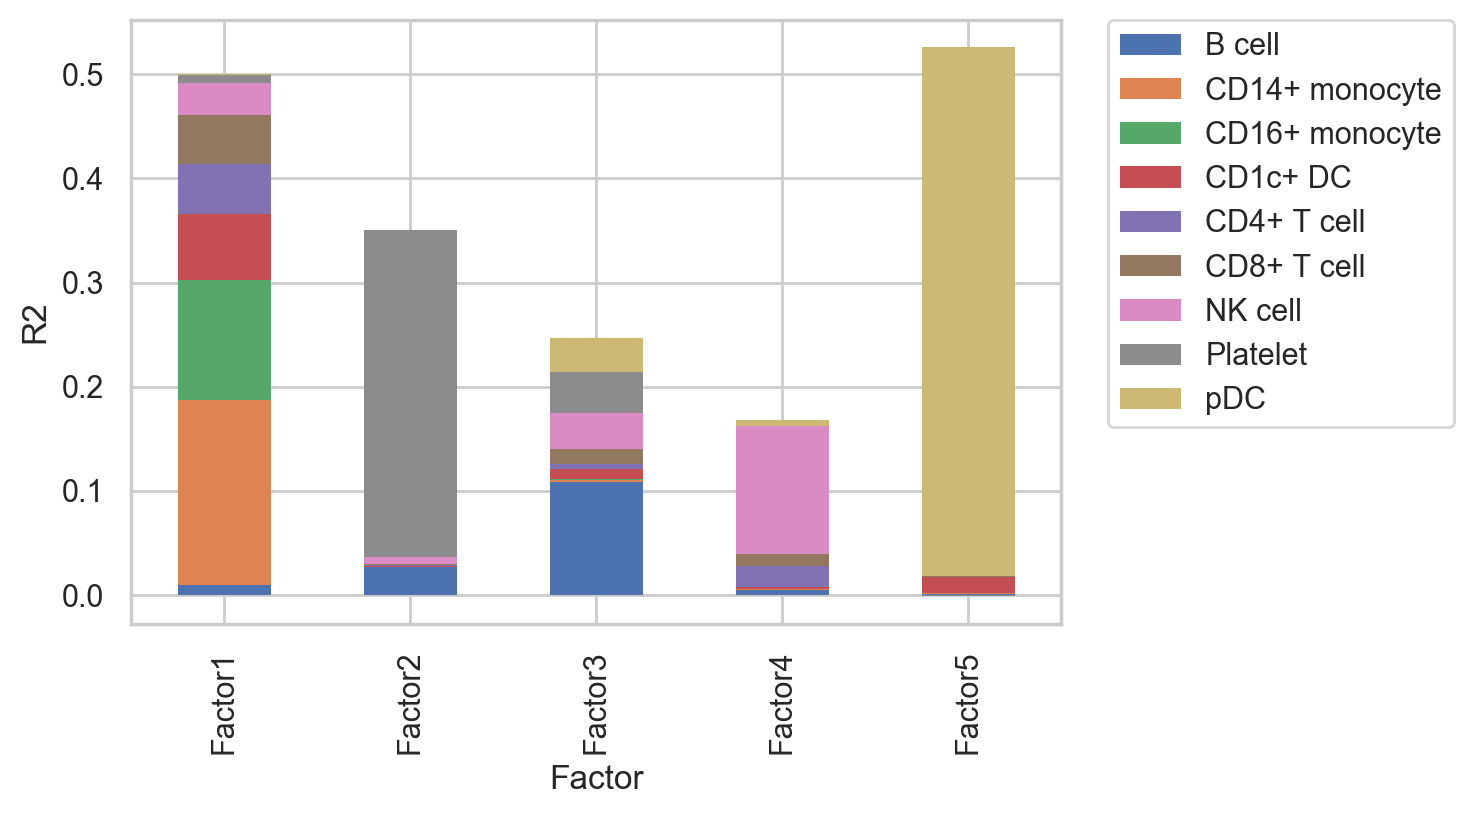

In [26]:
mfx.plot_r2_barplot(m, group_label="celltype", factors=list(range(5)), stacked=True)

Alternatively, one can also focus on groups of cells and plot them along the X axis:

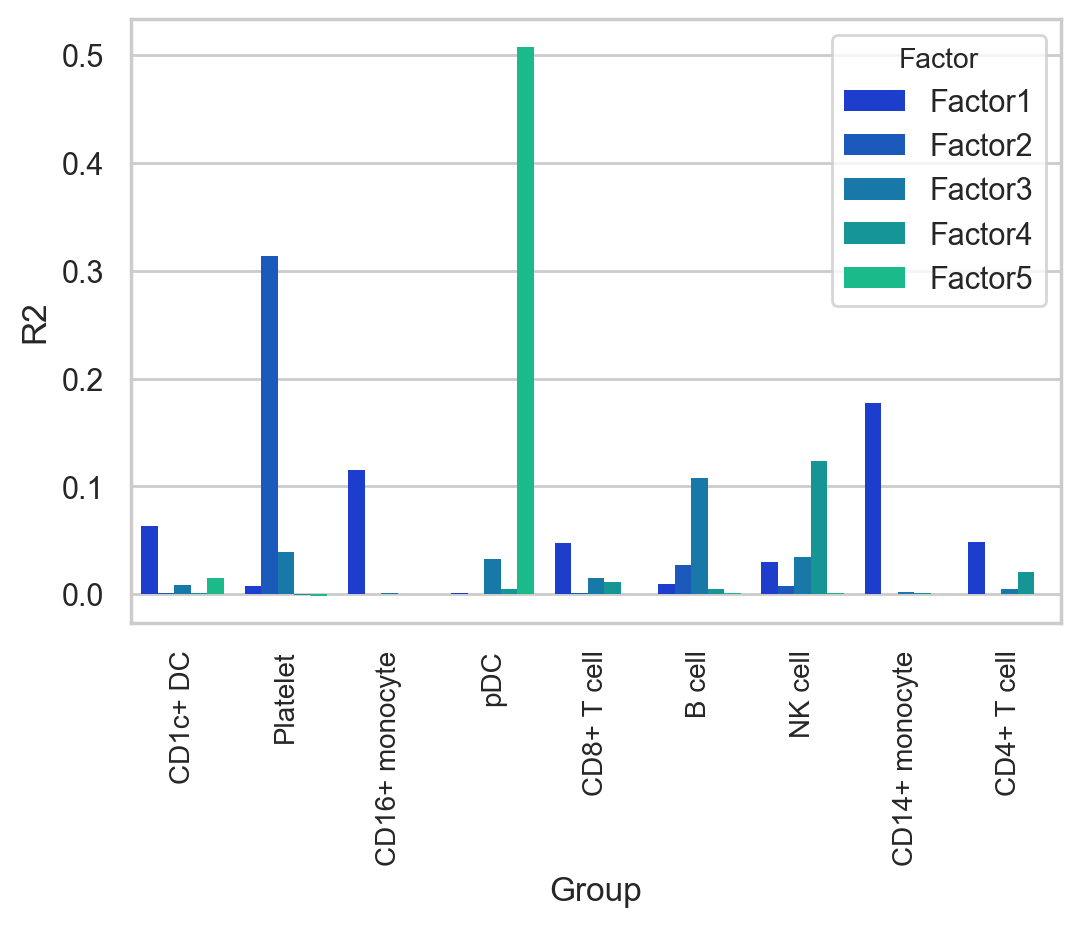

In [27]:
mfx.plot_r2_barplot(m, factors=list(range(5)), x="Group", groupby="Factor",
                    groups_df=celltypes,
                    palette="winter")

Slightly more advanced usage includes providing a **custrom grouping** of cells so that R2 values are calculated for new groups and **permutation test** to calculate and plot empirical p-values using re-shuffled group labels instead of R2 values as a heatmap.

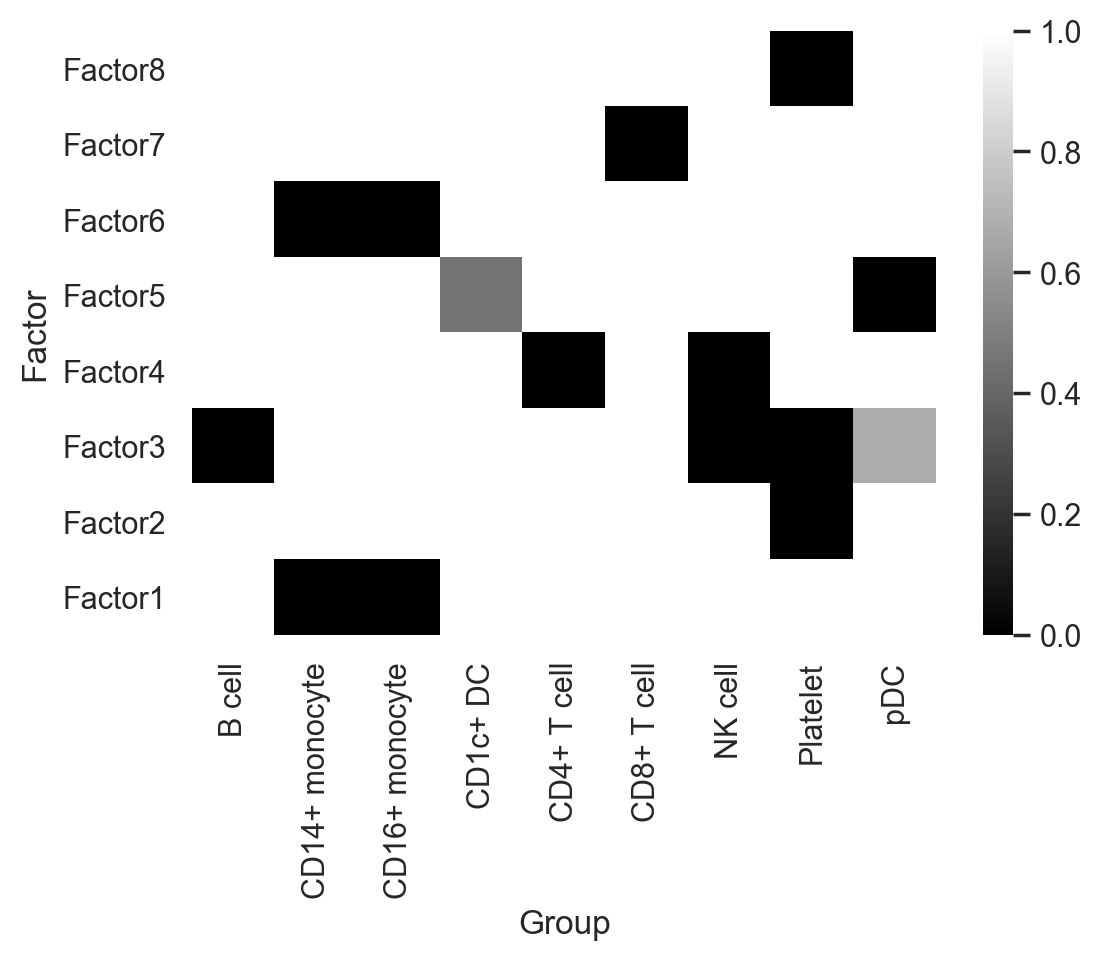

In [28]:
mfx.plot_r2_pvalues(m, group_label="celltype", factors=list(range(8)), n_iter=10)

# Plotting factors

Factor values describe how prominent a particular process (factor) is for each cell.

Currently the following functions are provided for plottings factor values:

- `plot_factors`,
- `plot_factors_scatter`,
- `plot_factors_matrixplot`.

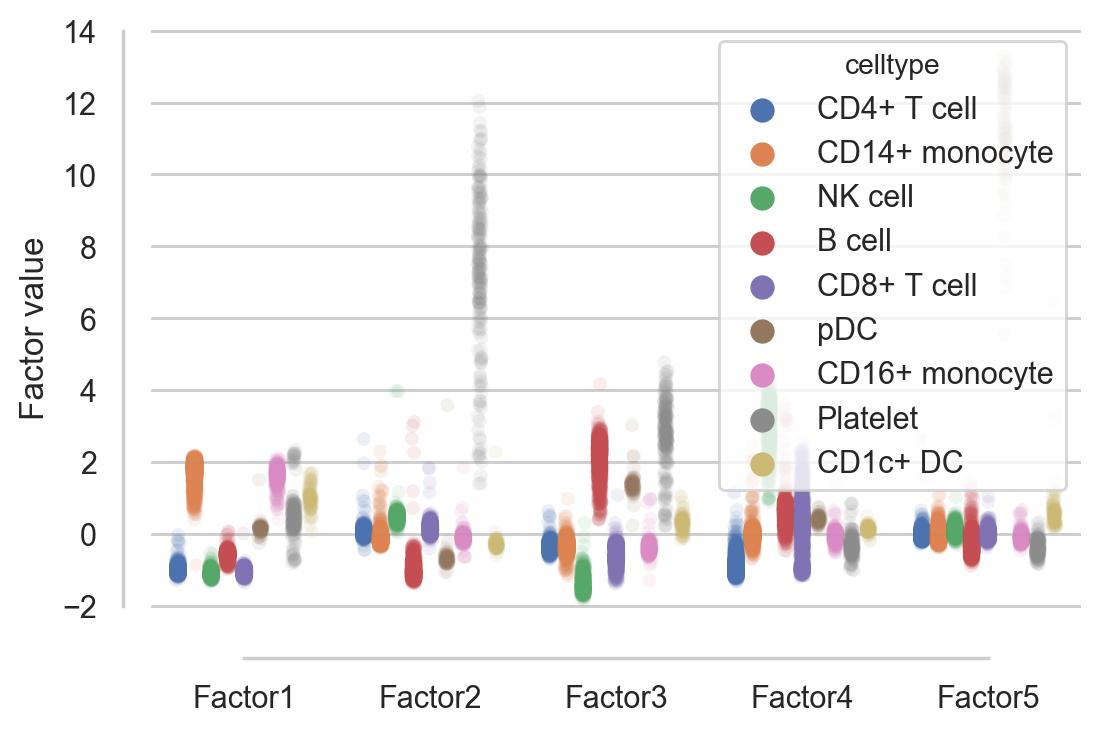

In [29]:
mfx.plot_factors(m, factors=list(range(5)), alpha=.1,
                 group_label="celltype", hue="celltype")

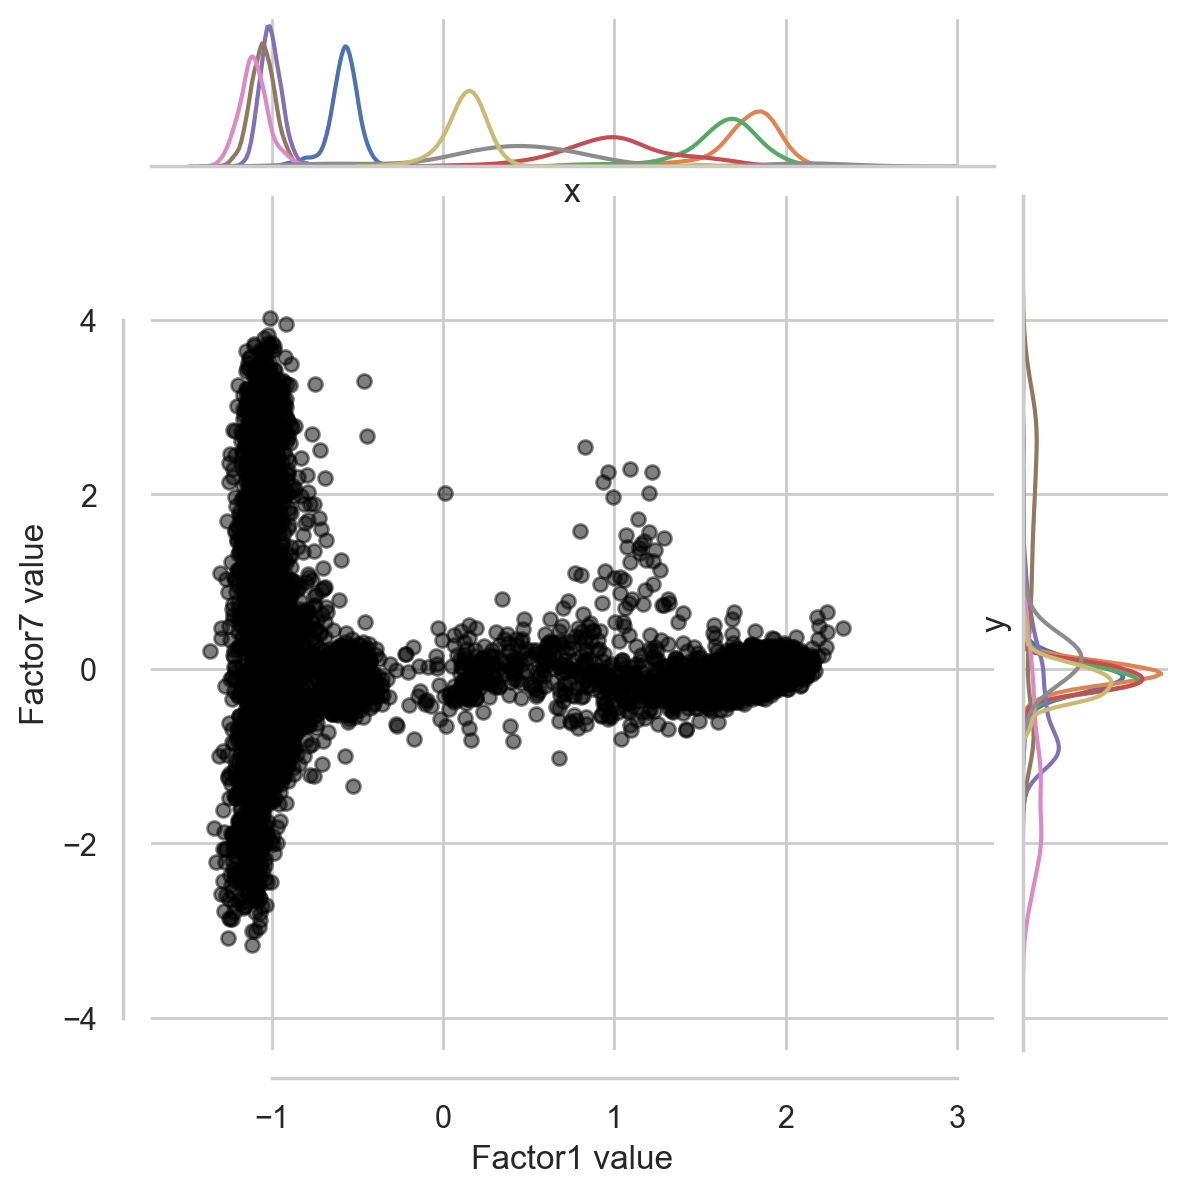

In [30]:
mfx.plot_factors_scatter(m, x="Factor1", y="Factor7", 
                         kde=True,
                         size=5, alpha=.5,
                         group_label="celltype") 

Multiple factor pairs can be visualised using subplots:

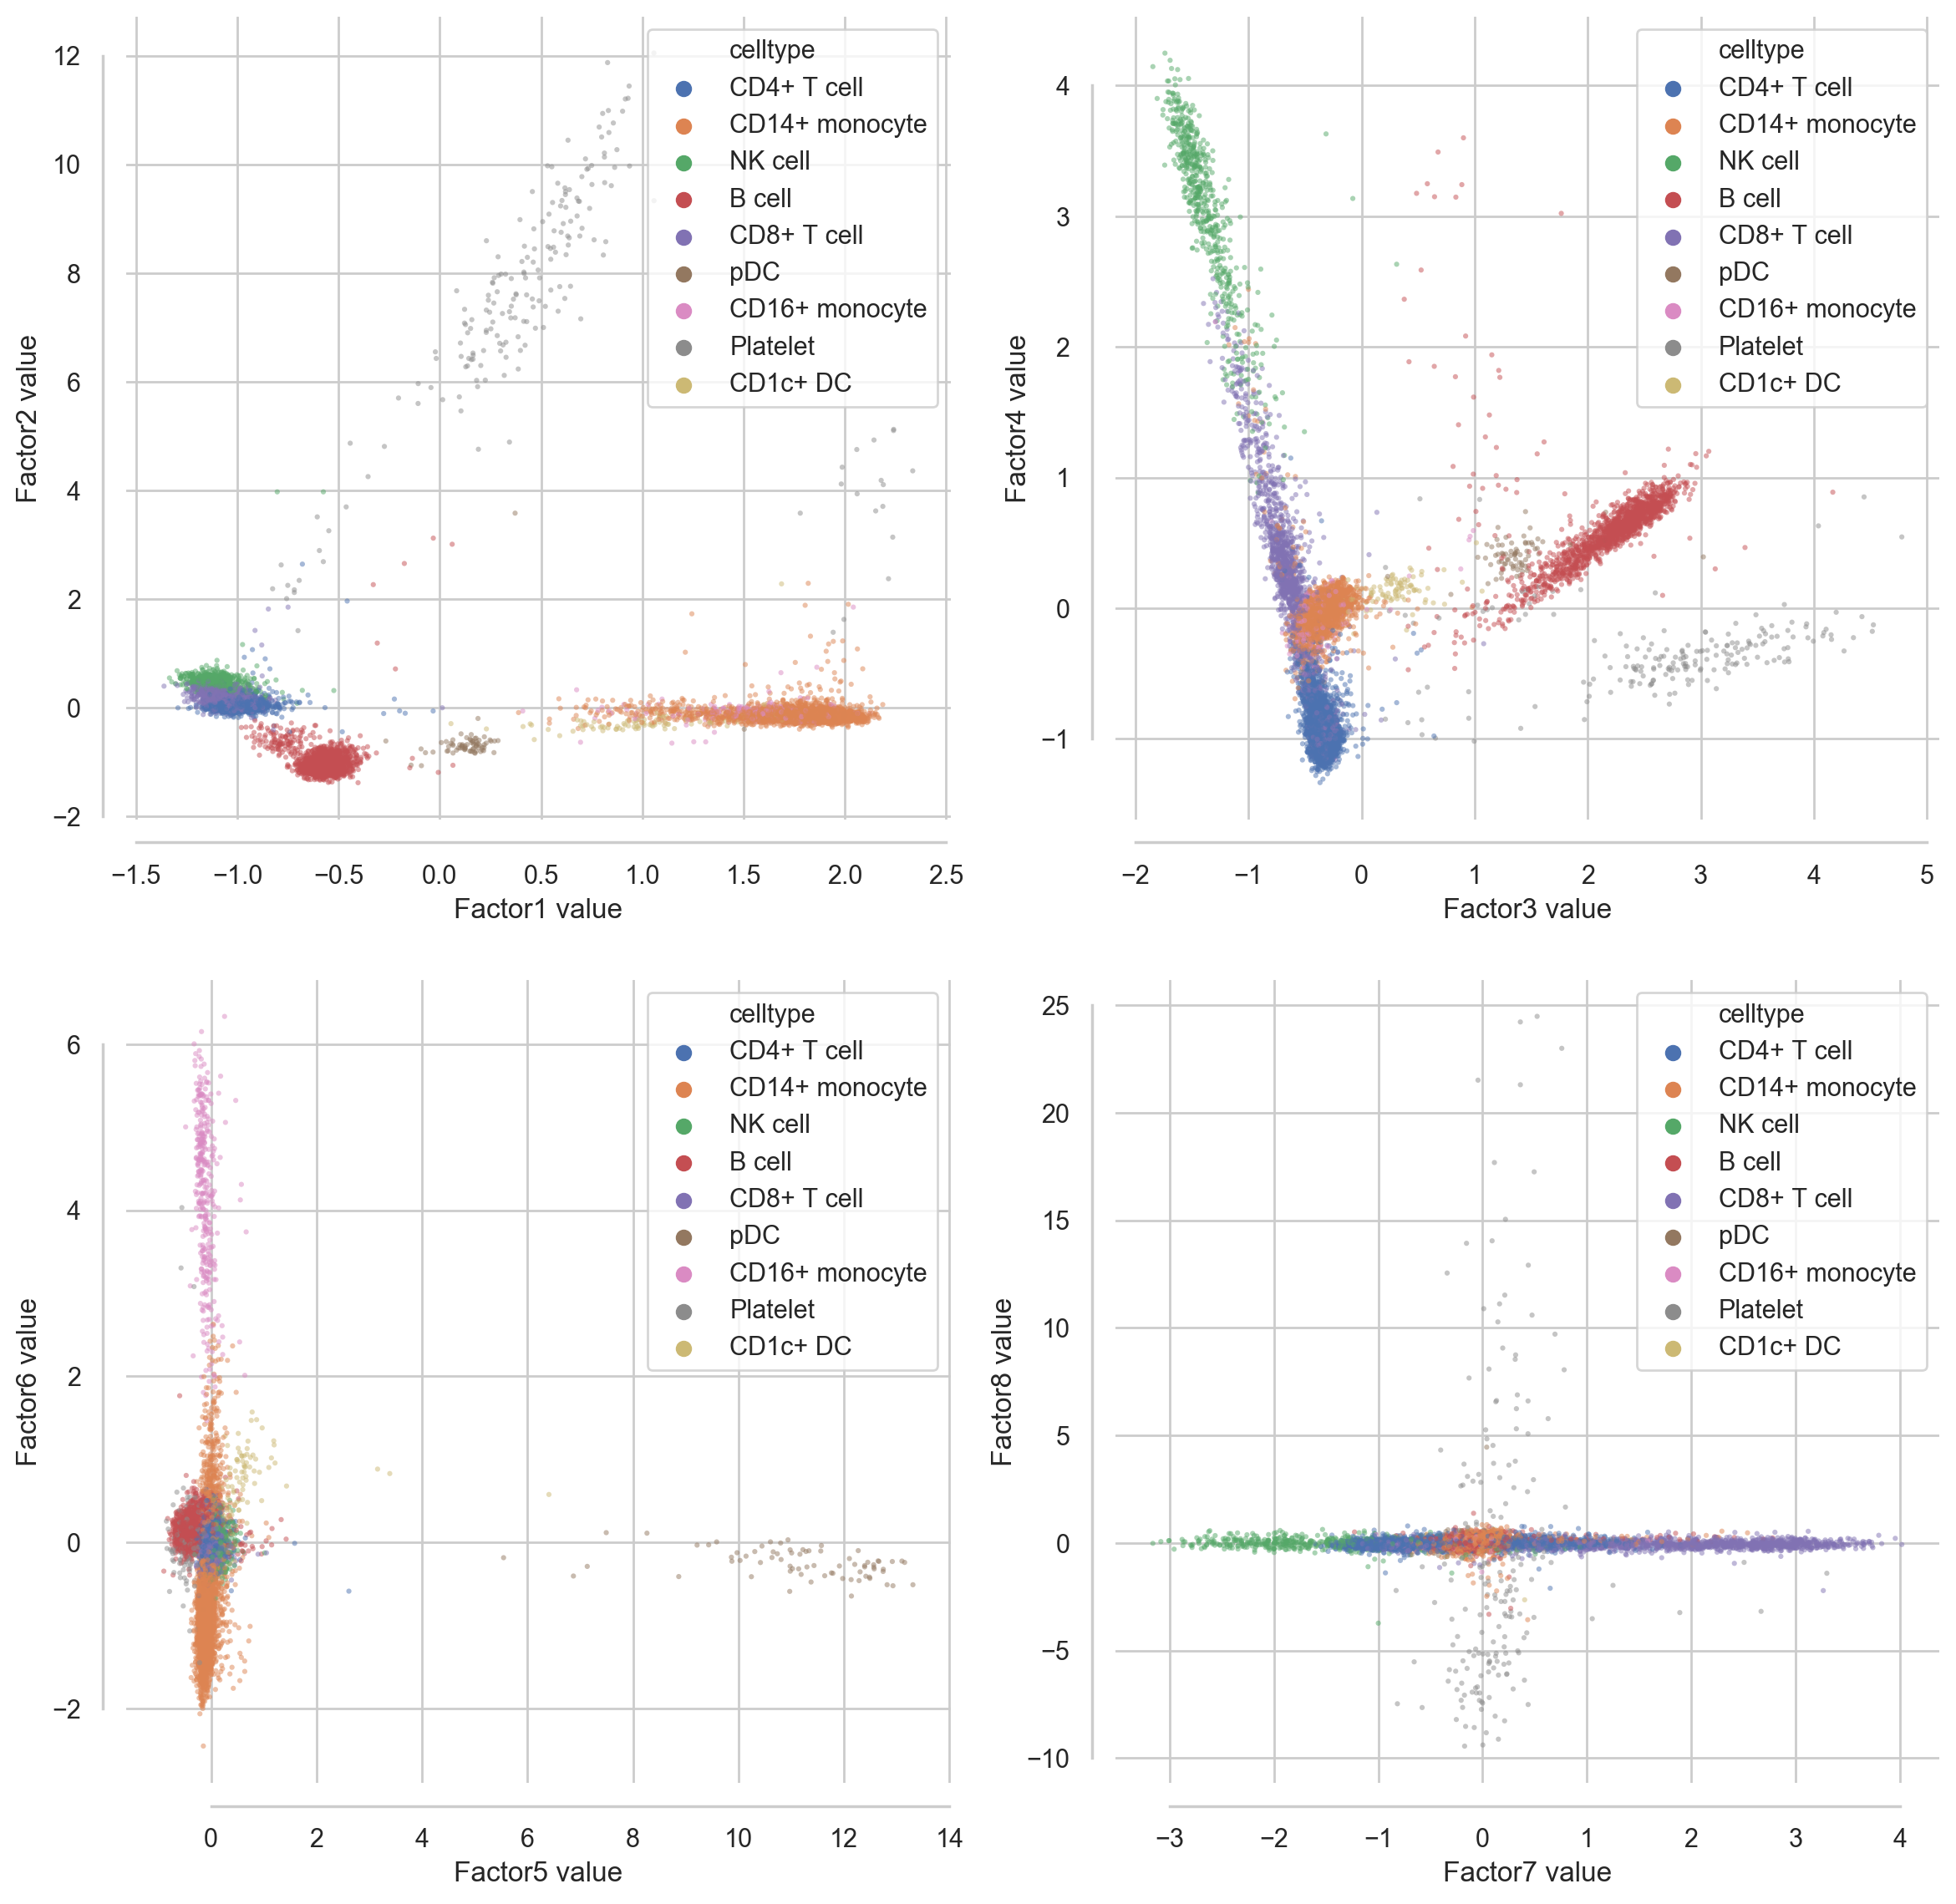

In [31]:
nf = 2  # rows/columns dimensions
f, axarr = plt.subplots(nf, nf, figsize=(14,14))
fnum = 0
for i in range(nf):
    for j in range(nf):
        mfx.plot_factors_scatter(m, x=fnum, y=fnum+1, size=5, alpha=.5, 
                         group_label="celltype", 
                         kde=False, hist=False, legend='brief', ax=axarr[i][j])
        fnum+=2

Factor values can be aggregated per group and plotted with `plot_factors_matrixplot`.

Aggregation functions accepted by [pandas.DataFrame.agg](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html) can be used, e.g.`"mean"` for mean or `"var"` for variance:

In [32]:
g = m.get_cells().set_index("cell")

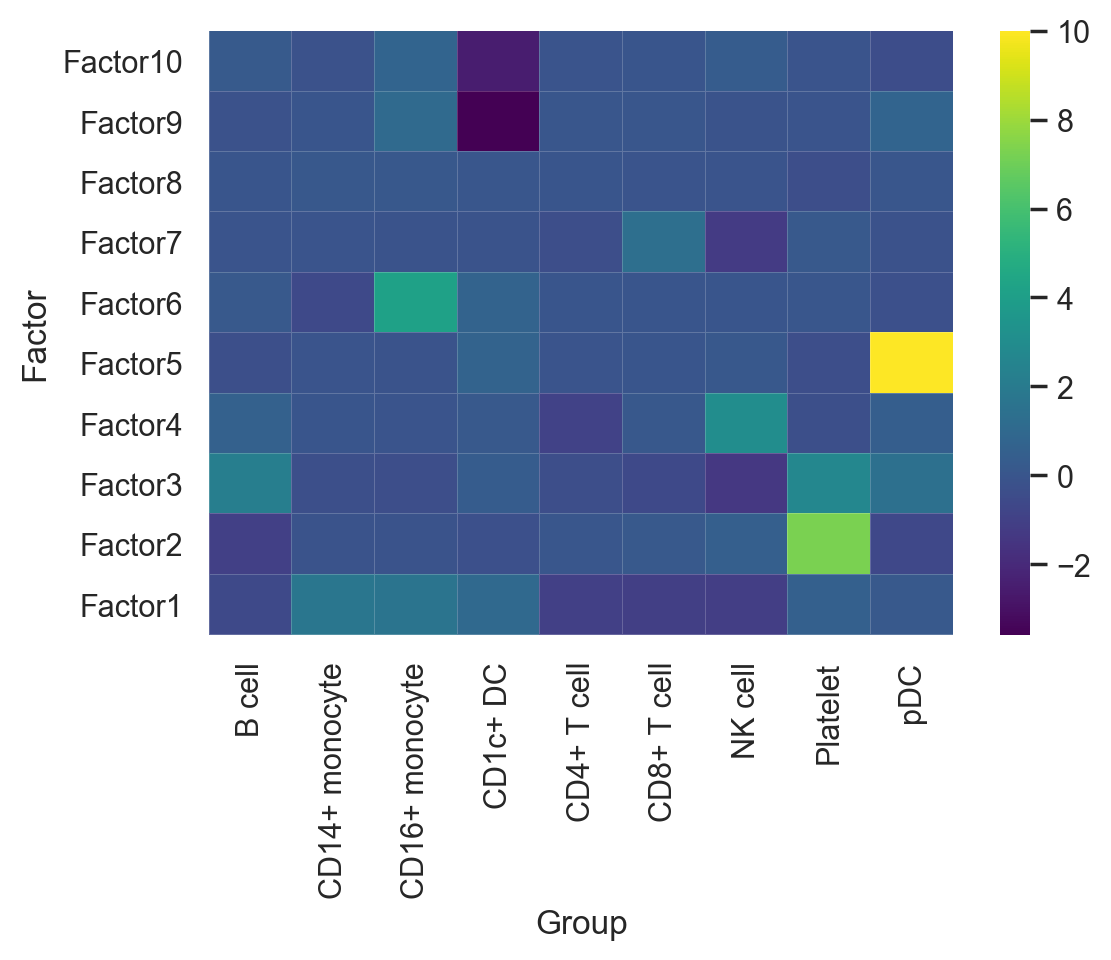

In [33]:
mfx.plot_factors_matrixplot(m, agg="mean", factors=list(range(10)), 
                            linewidths=0.01, linecolor="#FFFFFF33",
                            vmax=10,
                            group_label="celltype")

And a heatmap with Pearson correlation coefficient values:

Text(0.5, 1, 'Pearson r')

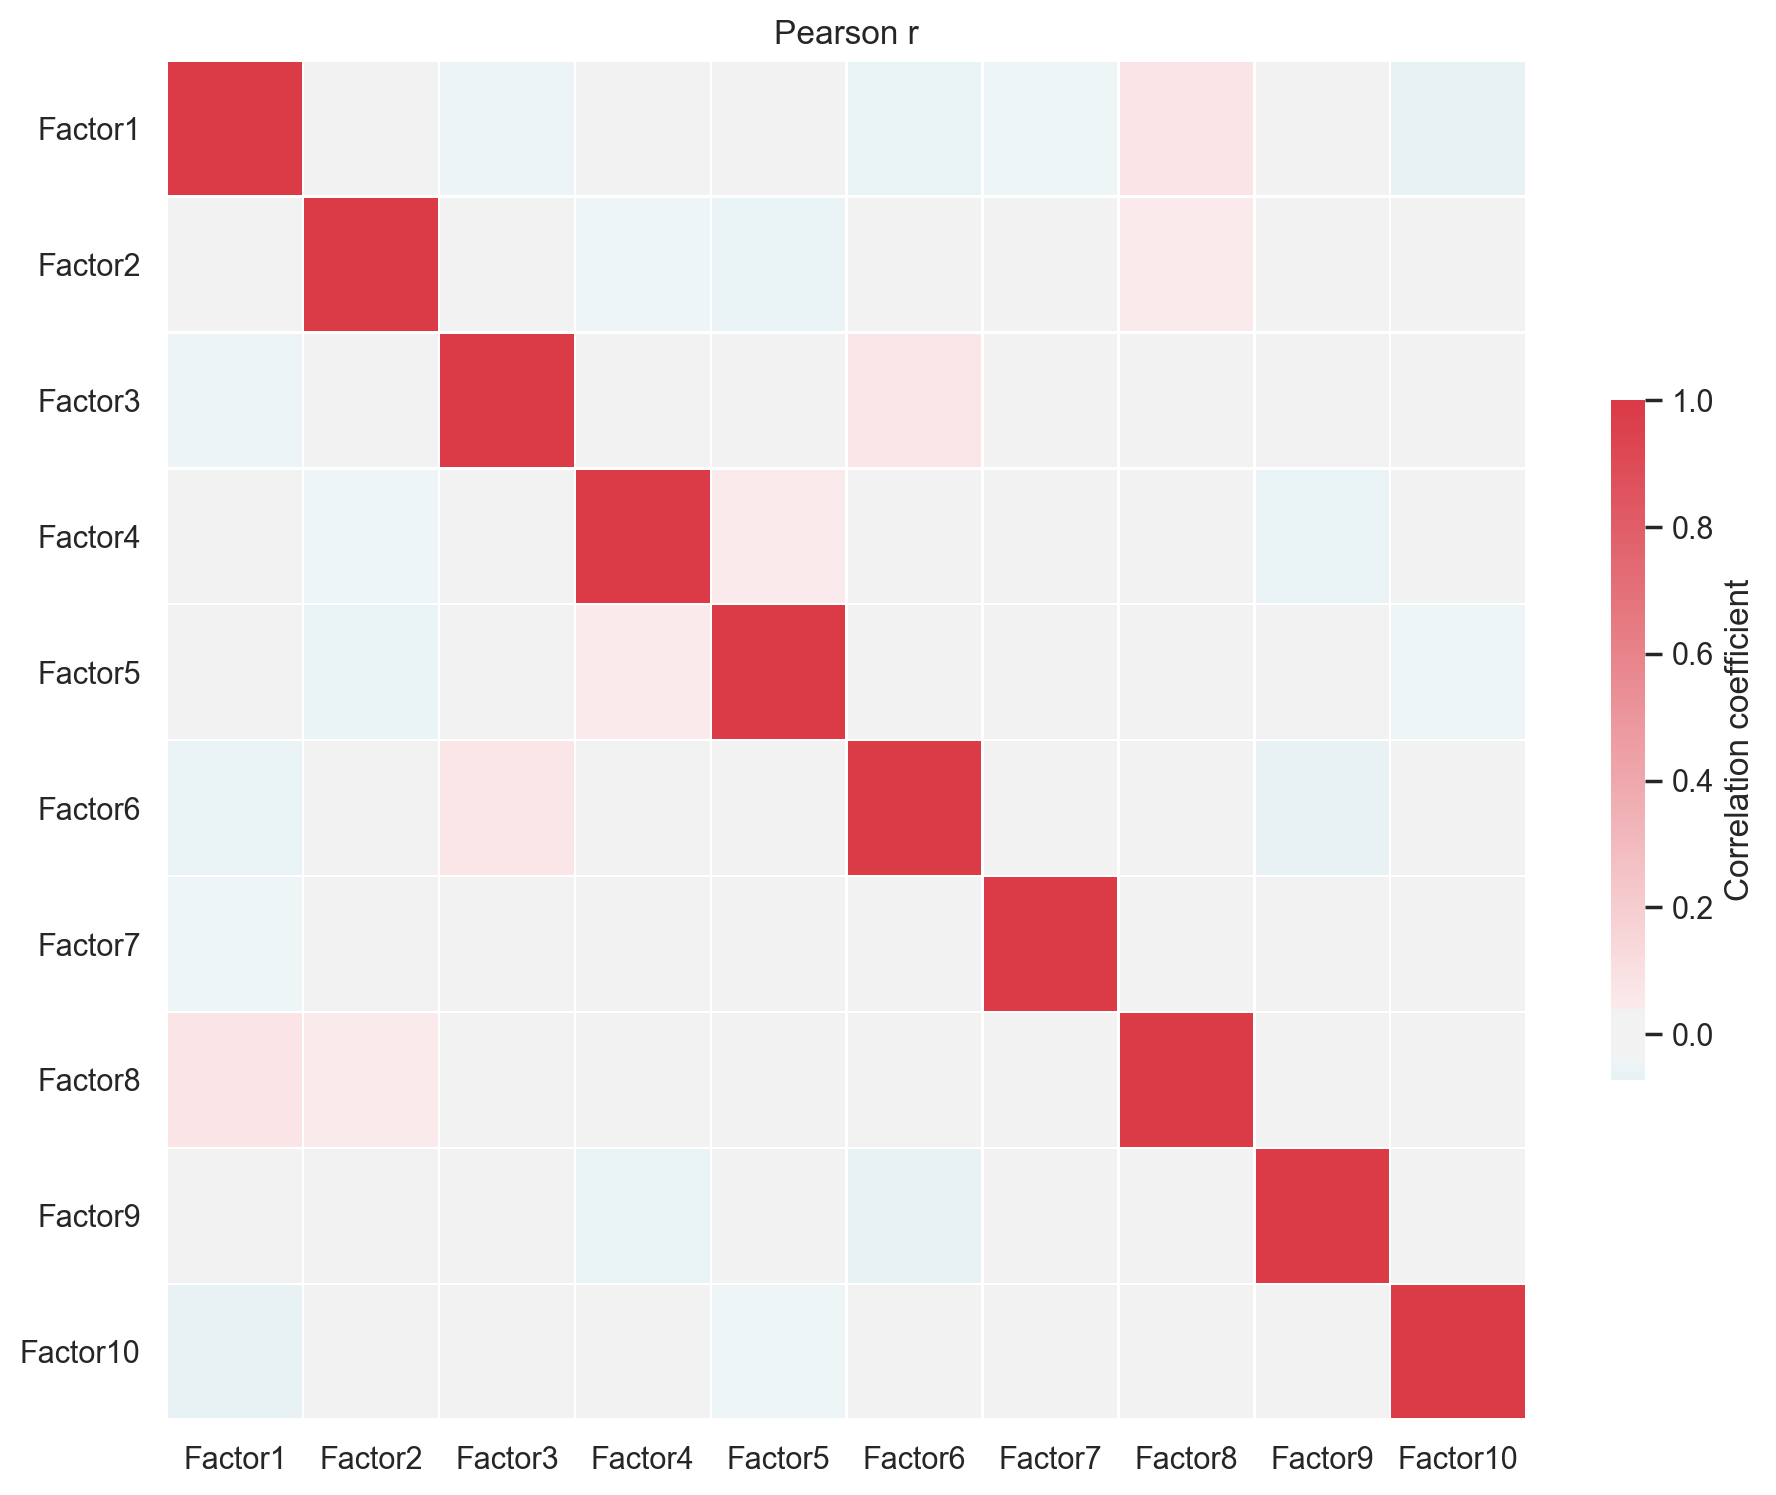

In [34]:
mfx.plot_factors_correlation(m); plt.title("Pearson r")

## Covariates

Typically, experiments have quite some information on cells or samples, for instance age or gender of patients in the clinical bulk sequencing data or number of counts per cell or pre-defined cell's type or state. We can correlate these values with factors in order to try to link some of the latter to some of the former.

Here, `pd.get_dummies()` might be useful in order to generate a one-hot encoding of some variables (wide table of 0's and 1's).

In [35]:
pd.get_dummies(m.metadata.celltype)

,B cell,CD14+ monocyte,CD16+ monocyte,CD1c+ DC,CD4+ T cell,CD8+ T cell,NK cell,Platelet,pDC
AAACCCAAGCGCCCAT-1,0,0,0,0,1,0,0,0,0
AAACCCACAGAGTTGG-1,0,1,0,0,0,0,0,0,0
AAACCCACAGGTATGG-1,0,0,0,0,0,0,1,0,0
AAACCCACATAGTCAC-1,1,0,0,0,0,0,0,0,0
AAACCCACATCCAATG-1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGCGTCGT-1,0,0,0,0,1,0,0,0,0
TTTGTTGGTGTCATGT-1,0,1,0,0,0,0,0,0,0
TTTGTTGGTTTGAACC-1,0,0,0,0,0,1,0,0,0
TTTGTTGTCCAAGCCG-1,0,0,0,0,1,0,0,0,0


Provided covariates can be a vector of corresponding length or a `pd.DataFrame`, in which case it should be index by sample (cell) as it is above.

Text(0.5, 1, 'Pearson r')

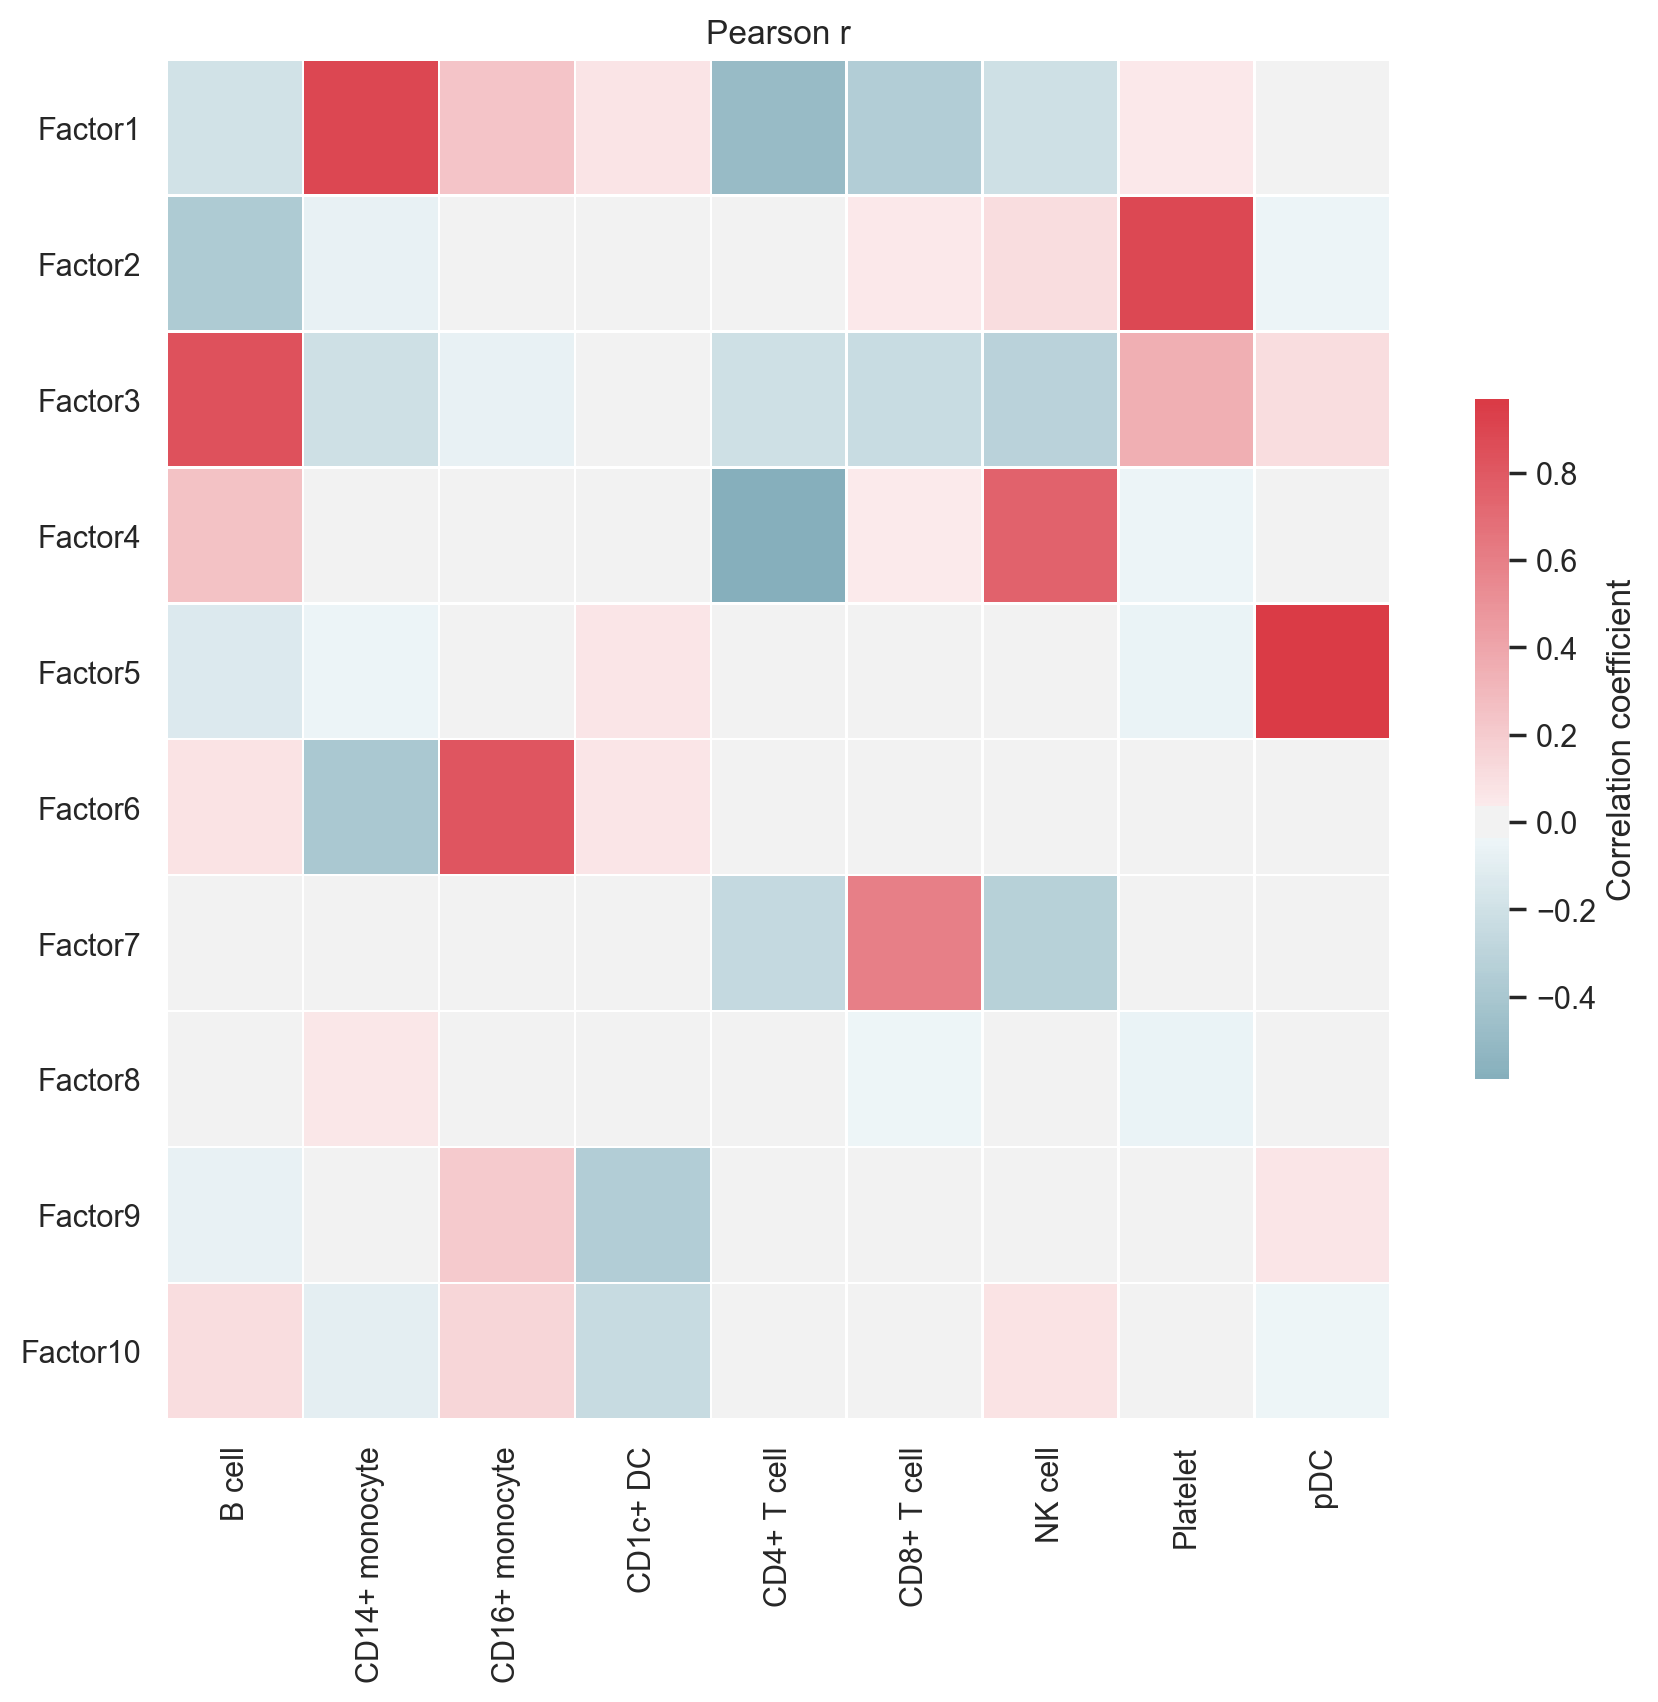

In [36]:
mfx.plot_factors_covariates_correlation(m, covariates=pd.get_dummies(m.metadata.celltype)); plt.title("Pearson r")

And adding `pvalues=True` allows to plot p-values for the correlation coefficients as implemented in [scipy.stats.personr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html). These p-values are corrected with Benjamini-Hochberg procedure before plotting.

/Users/bredikhi/git/compbio/mofax/mofax/plot.py:1042: RuntimeWarning: divide by zero encountered in log10
  corr = -np.log10(corr)
/Users/bredikhi/git/compbio/mofax/mofax/plot.py:1045: UserWarning: Some p-values are 0, these values will be capped.
  warn("Some p-values are 0, these values will be capped.")


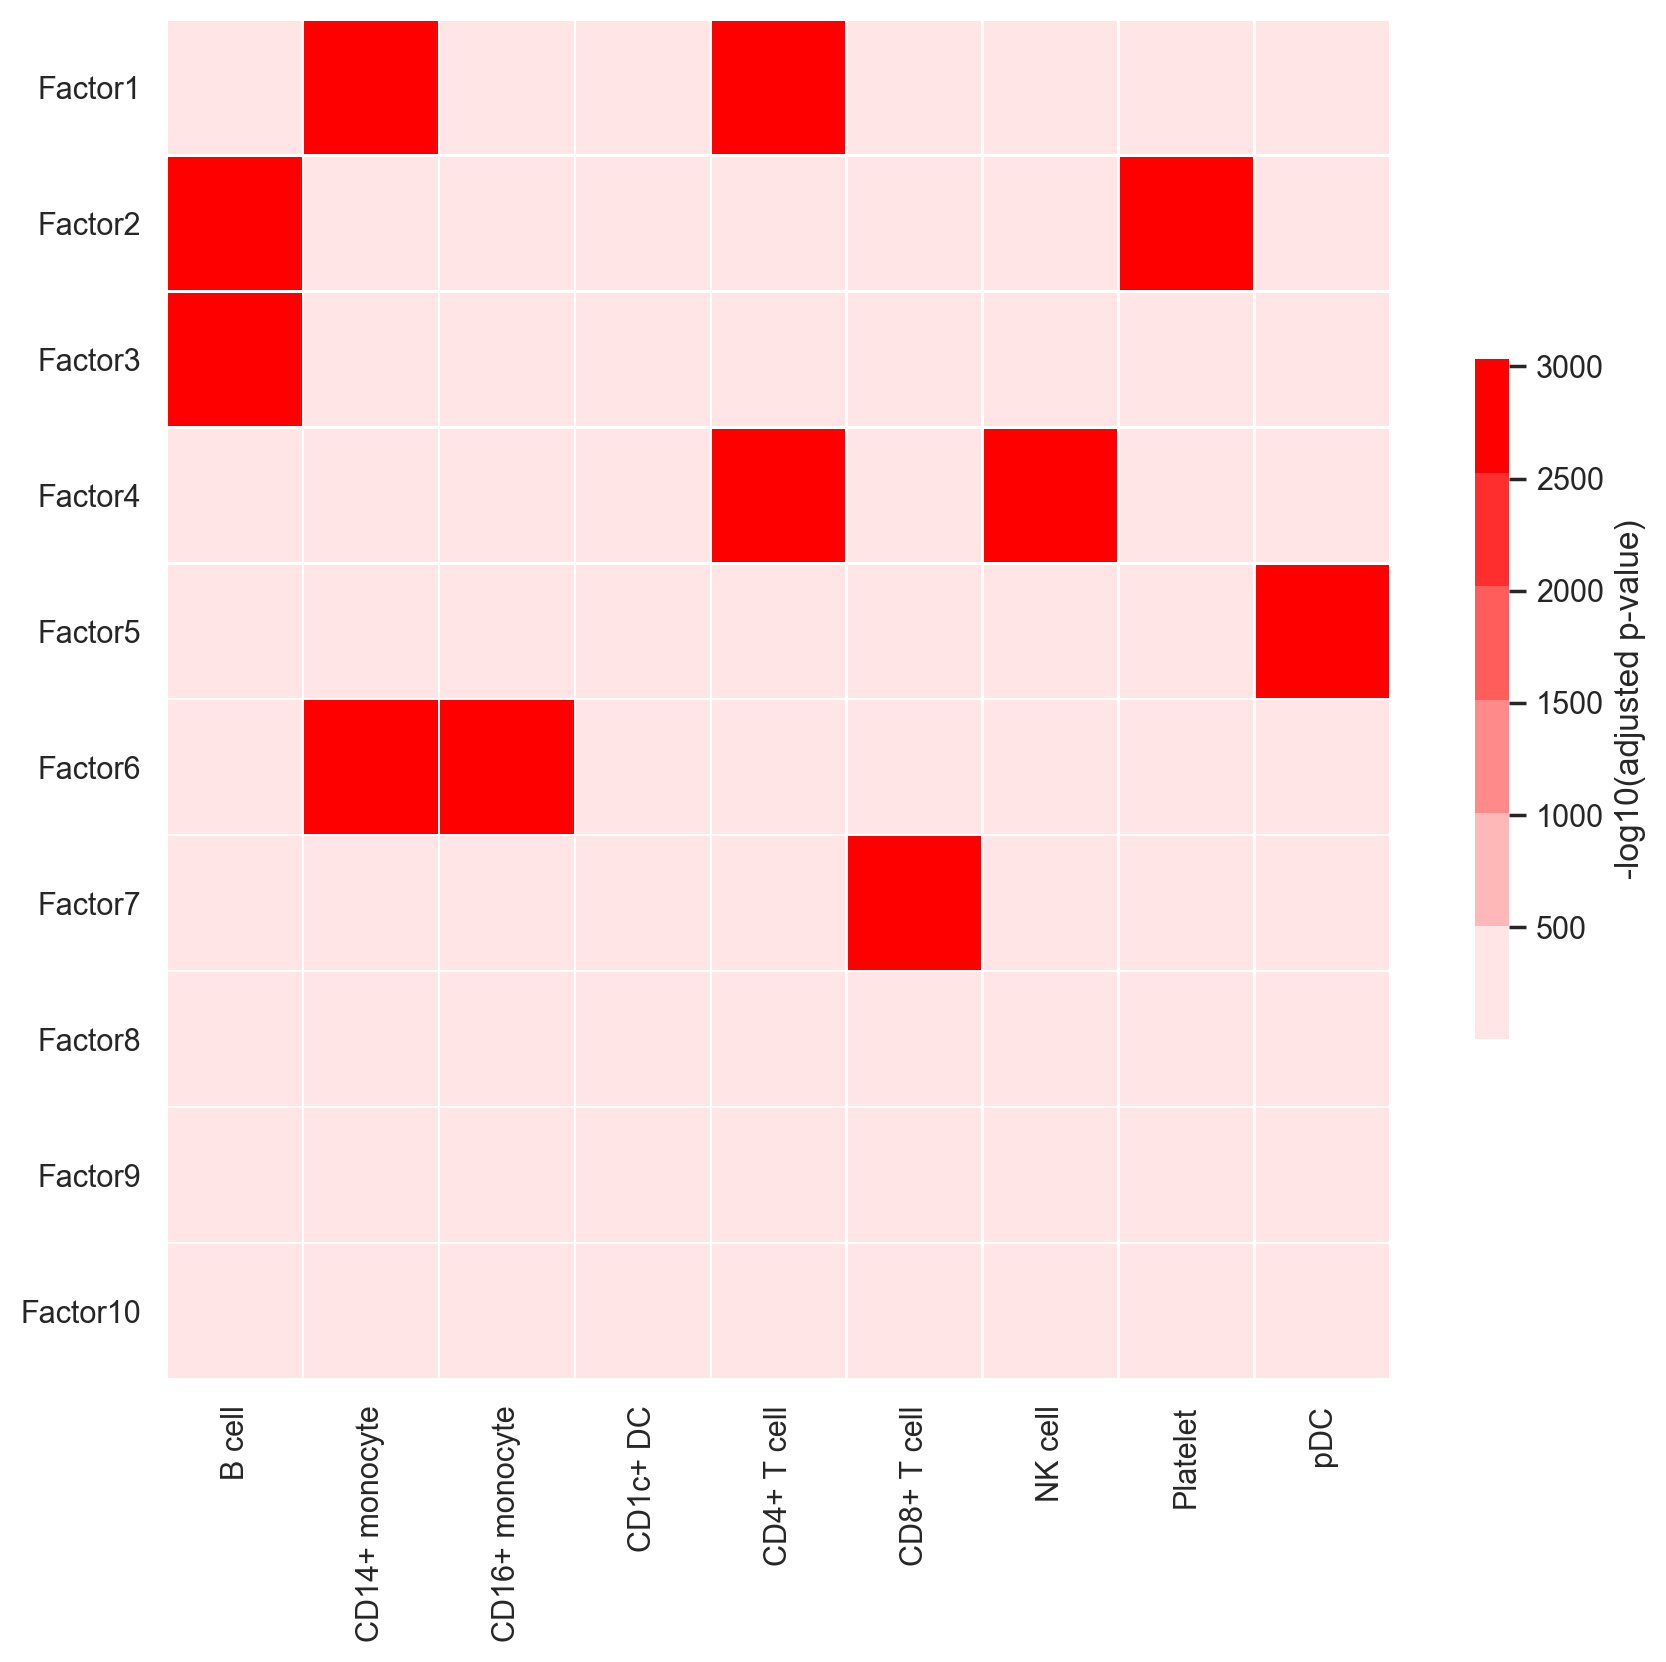

In [37]:
mfx.plot_factors_covariates_correlation(m, covariates=pd.get_dummies(m.metadata.celltype), pvalues=True, cmap=sns.light_palette("#FF0000"))